In [1]:
#В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

#Объективные признаки:

# - Возраст
# - Рост
# - Вес
# - Пол
# 
#Результаты измерения:

# - Артериальное давление верхнее и нижнее
# - Холестерин
# - Глюкоза
 
#Субъективные признаки:

# - Курение
# - Употребление Алкоголя
# - Физическая активность
 
#Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

#Все показатели даны на момент осмотра.

#Последняя группа признаков не имеет однозначной интерпретации и более того, собрана со слов самого больного. Поэтому, для части данных в тестовой выборке мы специально исключили эти параметры. Участникам придется либо предсказать их самостоятельно для некоторых случаев, либо вовсе игнорировать.

#Данные поделены в соотношении 70/10/20. Тренировочная выборка состоит из 70 тысяч результатов, еще по десяти тысячам считается публичная метрика, доступная участникам в ходе соревнования. Оставшиеся 20 тысяч отправились в скрытую проверочную выборку, подсчет метрики по которой и определит победителей в финале.

#Поскольку мы имеем дело с бинарной классификацией, метрикой является логарифмическая функция потерь.

#В прилагаемом к задаче архиве есть два файла:

# - train.csv содержит тренировочные данные, включая наличие ССЗ (колонка cardio)
# - test.csv содержит данные для проверки, колонка cardio в этом файле отсутствует

#Загружаемое решение должно быть в формате csv, без заголовка. Поскольку мы оперируем лишь одним целевым признаком, фактически мы ожидаем от участников загрузку файла, где по порядку на каждой строке находится предсказание вероятности появления ССЗ для каждой из строк файла test.csv.

In [2]:
import pandas as pd
import numpy as np
from pandas import read_csv, DataFrame
from sklearn import tree
from sklearn import ensemble
#from sklearn.metrics import r2_score

#from sklearn.feature_extraction import DictVectorizer
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import KFold

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

dataset = read_csv('train.csv', sep=";")
datasetTest = read_csv('test.csv', sep=";")

#dataset = read_csv('weilume.csv', nrows=10000)

In [3]:
dataset.head()

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

In [4]:
dataset.tail()

id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
69995  99993  19240       2     168    76.0    120     80            1     1   
69996  99995  22601       1     158   126.0    140     90            2     2   
69997  99996  19066       2     183   105.0    180     90            3     1   
69998  99998  22431       1     163    72.0    135     80            1     2   
69999  99999  20540       1     170    72.0    120     80            2     1   

       smoke  alco  active  cardio  
69995      1     0       1       0  
69996      0     0       1       1  
69997      0     1       0       1  
69998      0     0       0       1  
69999      0     0       1       0

In [5]:
dataset.describe()

id           age        gender        height        weight  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean   49972.419900  19468.865814      1.349571    164.359229     74.205690   
std    28851.302323   2467.251667      0.476838      8.210126     14.395757   
min        0.000000  10798.000000      1.000000     55.000000     10.000000   
25%    25006.750000  17664.000000      1.000000    159.000000     65.000000   
50%    50001.500000  19703.000000      1.000000    165.000000     72.000000   
75%    74889.250000  21327.000000      2.000000    170.000000     82.000000   
max    99999.000000  23713.000000      2.000000    250.000000    200.000000   

              ap_hi         ap_lo   cholesterol          gluc         smoke  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean     128.817286     96.630414      1.366871      1.226457      0.088129   
std      154.011419    188.472530      0.680250      0.572270      0.283484   
min     -150.000000    -70.000000      1.000000      1.000000      0.000000   
25%      120.000000     80.000000      1.000000      1.000000      0.000000   
50%      120.000000     80.000000      1.000000      1.000000      0.000000   
75%      140.000000     90.000000      2.000000      1.000000      0.000000   
max    16020.000000  11000.000000      3.000000      3.000000      1.000000   

               alco        active        cardio  
count  70000.000000  70000.000000  70000.000000  
mean       0.053771      0.803729      0.499700  
std        0.225568      0.397179      0.500003  
min        0.000000      0.000000      0.000000  
25%        0.000000      1.000000      0.000000  
50%        0.000000      1.000000      0.000000  
75%        0.000000      1.000000      1.000000  
max        1.000000      1.000000      1.000000

In [6]:
dataset = dataset.drop('id', axis=1)
datasetTest = datasetTest.drop('id', axis=1)

In [7]:
datasetTest = datasetTest.replace('None', np.nan)

In [8]:
datasetTest['active'].describe()

count     27103
unique        2
top           1
freq      21843
Name: active, dtype: object

In [9]:
datasetTest['smoke'] = datasetTest['smoke'].fillna(0).astype(int)
datasetTest['alco'] = datasetTest['alco'].fillna(0).astype(int)
datasetTest['active'] = datasetTest['active'].fillna(1).astype(int)

In [10]:
datasetTest.describe()

age        gender        height        weight         ap_hi  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean   19455.528400      1.353733    164.322267     74.120615    130.271300   
std     2477.840922      0.478136      8.213740     14.341540    212.501152   
min     8865.000000      1.000000     50.000000     10.000000   -130.000000   
25%    17658.000000      1.000000    159.000000     65.000000    120.000000   
50%    19694.000000      1.000000    165.000000     72.000000    120.000000   
75%    21320.000000      2.000000    170.000000     82.000000    140.000000   
max    23705.000000      2.000000    198.000000    183.000000  16020.000000   

              ap_lo   cholesterol          gluc         smoke          alco  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      95.689000      1.368033      1.222700      0.078967      0.048967   
std      163.852598      0.679166      0.566494      0.269691      0.215802   
min      -90.000000      1.000000      1.000000      0.000000      0.000000   
25%       80.000000      1.000000      1.000000      0.000000      0.000000   
50%       80.000000      1.000000      1.000000      0.000000      0.000000   
75%       90.000000      2.000000      1.000000      0.000000      0.000000   
max     9100.000000      3.000000      3.000000      1.000000      1.000000   

             active  
count  30000.000000  
mean       0.824667  
std        0.380258  
min        0.000000  
25%        1.000000  
50%        1.000000  
75%        1.000000  
max        1.000000

In [11]:
datasetTest['smoke'].describe()

count    30000.000000
mean         0.078967
std          0.269691
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: smoke, dtype: float64

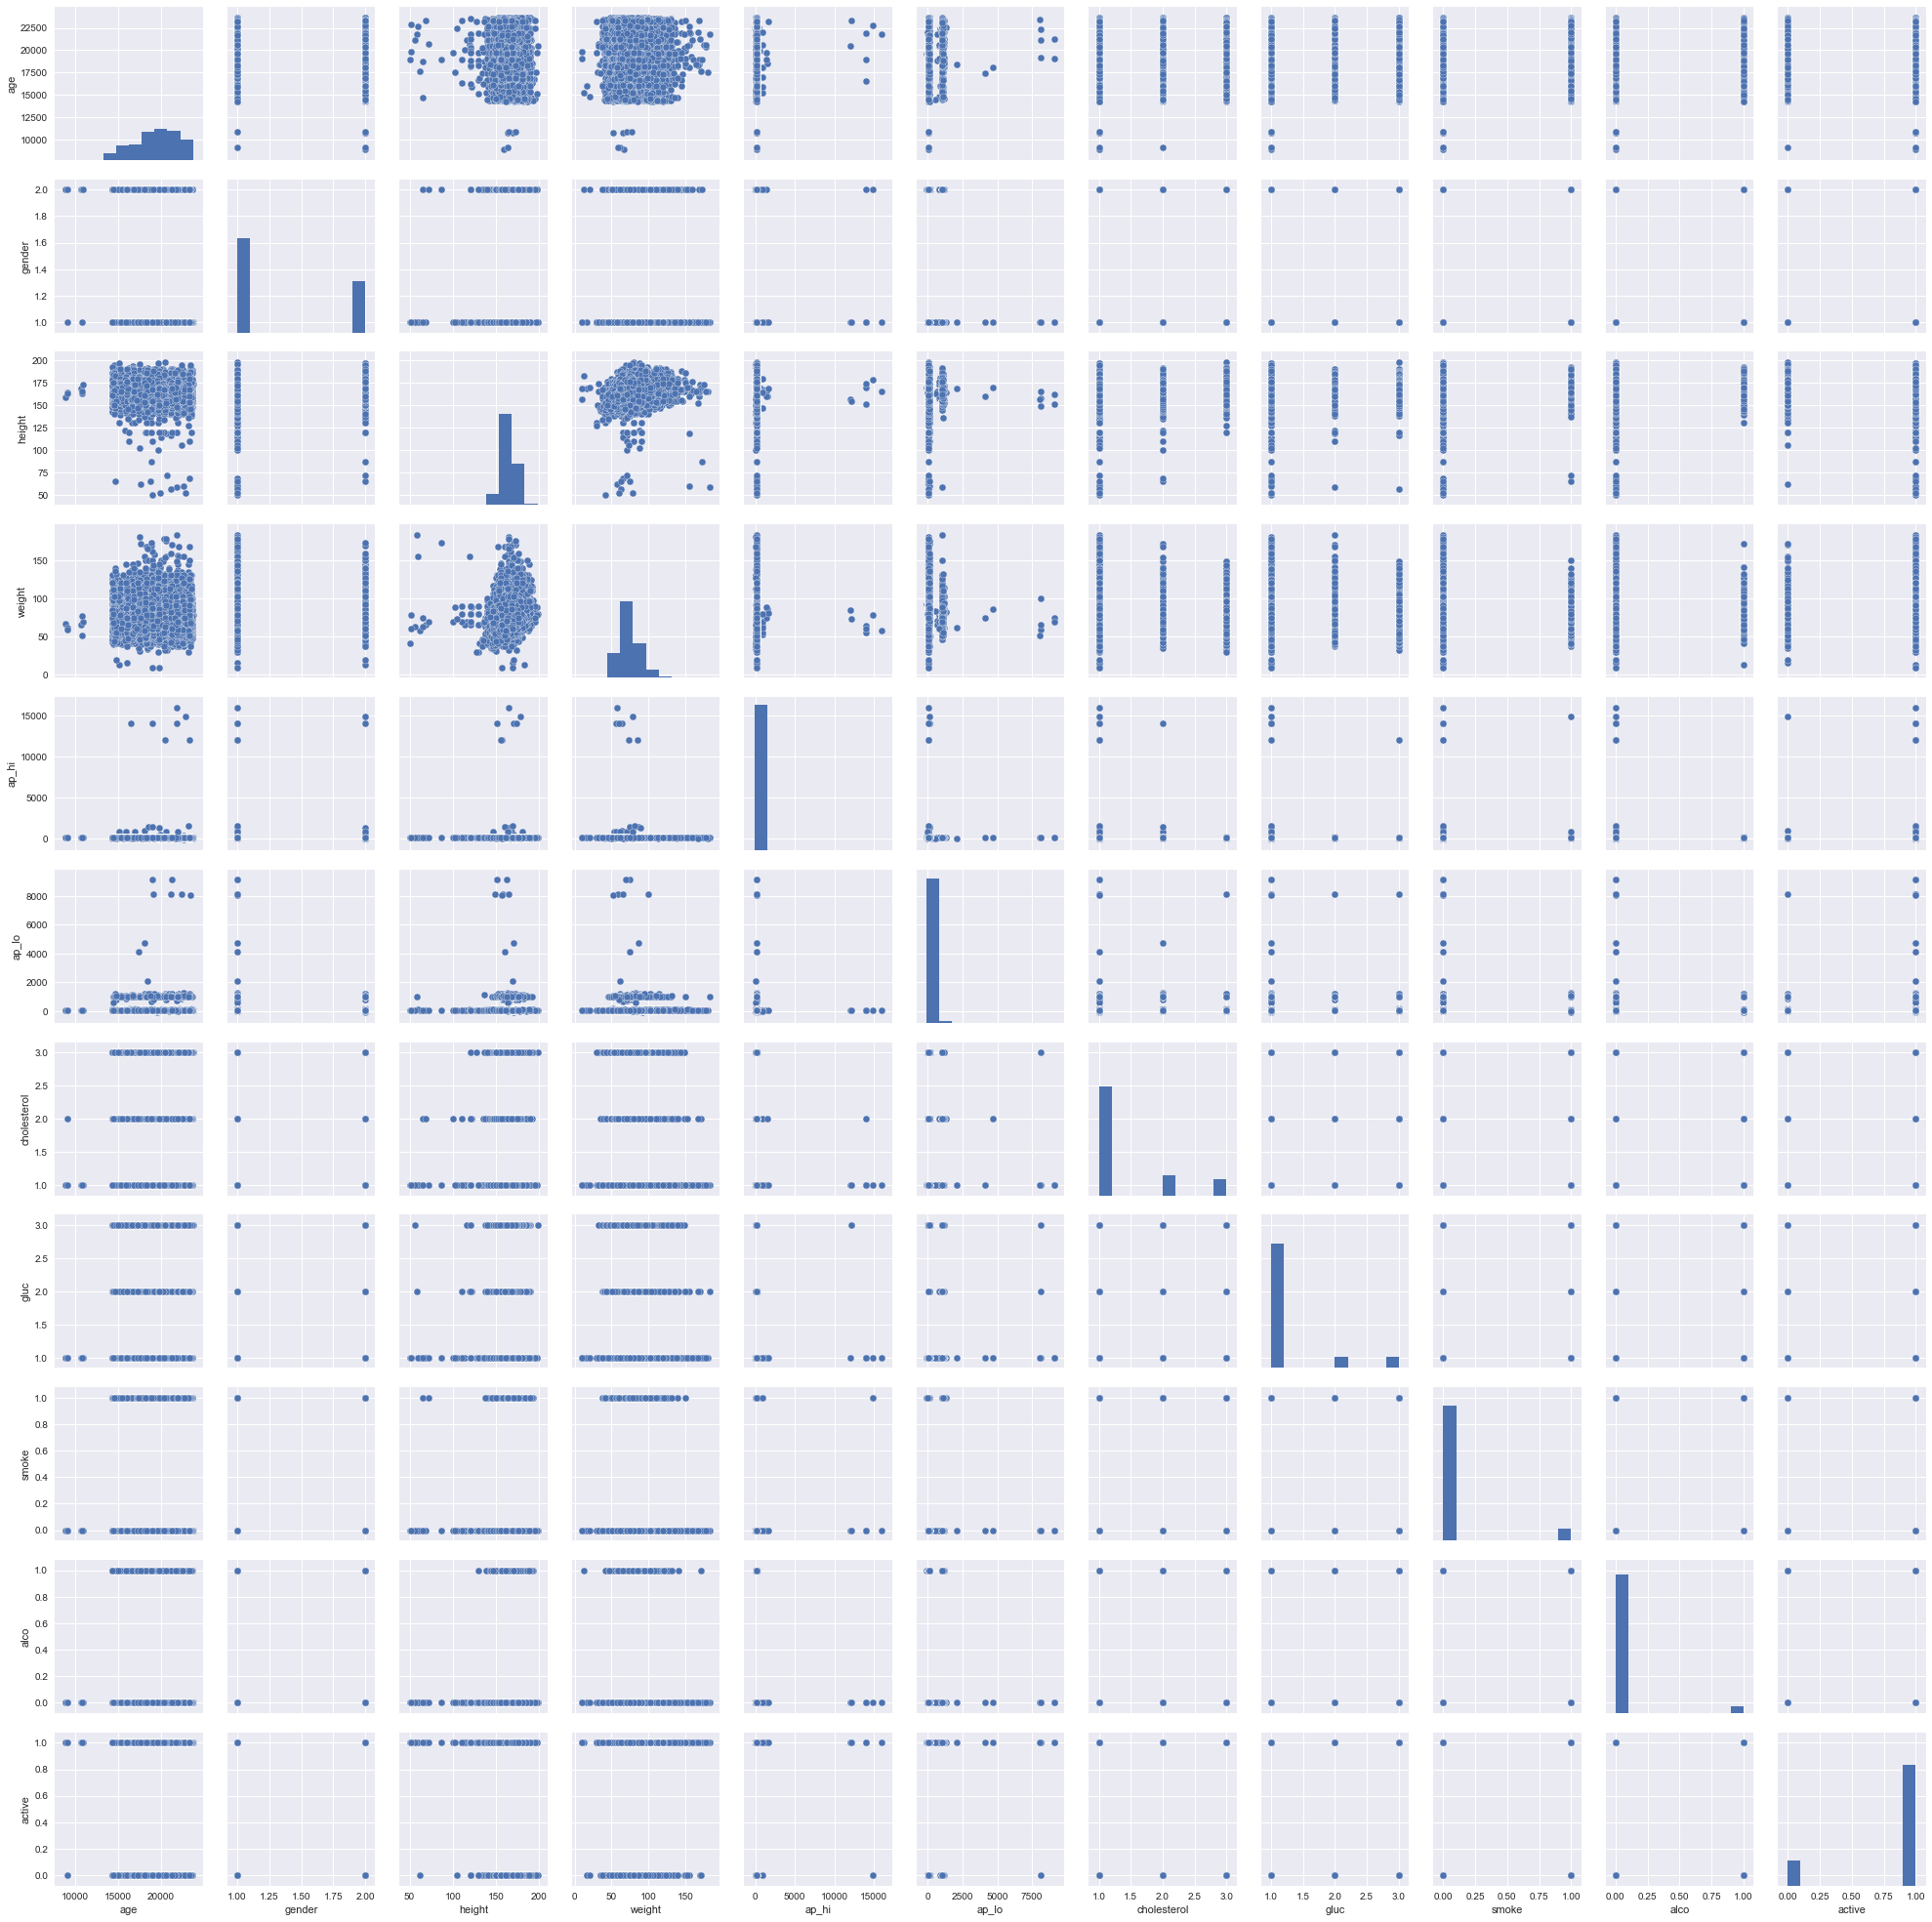

In [12]:
sns.pairplot(datasetTest)

In [13]:
dataset.describe()

age        gender        height        weight         ap_hi  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean   19468.865814      1.349571    164.359229     74.205690    128.817286   
std     2467.251667      0.476838      8.210126     14.395757    154.011419   
min    10798.000000      1.000000     55.000000     10.000000   -150.000000   
25%    17664.000000      1.000000    159.000000     65.000000    120.000000   
50%    19703.000000      1.000000    165.000000     72.000000    120.000000   
75%    21327.000000      2.000000    170.000000     82.000000    140.000000   
max    23713.000000      2.000000    250.000000    200.000000  16020.000000   

              ap_lo   cholesterol          gluc         smoke          alco  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean      96.630414      1.366871      1.226457      0.088129      0.053771   
std      188.472530      0.680250      0.572270      0.283484      0.225568   
min      -70.000000      1.000000      1.000000      0.000000      0.000000   
25%       80.000000      1.000000      1.000000      0.000000      0.000000   
50%       80.000000      1.000000      1.000000      0.000000      0.000000   
75%       90.000000      2.000000      1.000000      0.000000      0.000000   
max    11000.000000      3.000000      3.000000      1.000000      1.000000   

             active        cardio  
count  70000.000000  70000.000000  
mean       0.803729      0.499700  
std        0.397179      0.500003  
min        0.000000      0.000000  
25%        1.000000      0.000000  
50%        1.000000      0.000000  
75%        1.000000      1.000000  
max        1.000000      1.000000

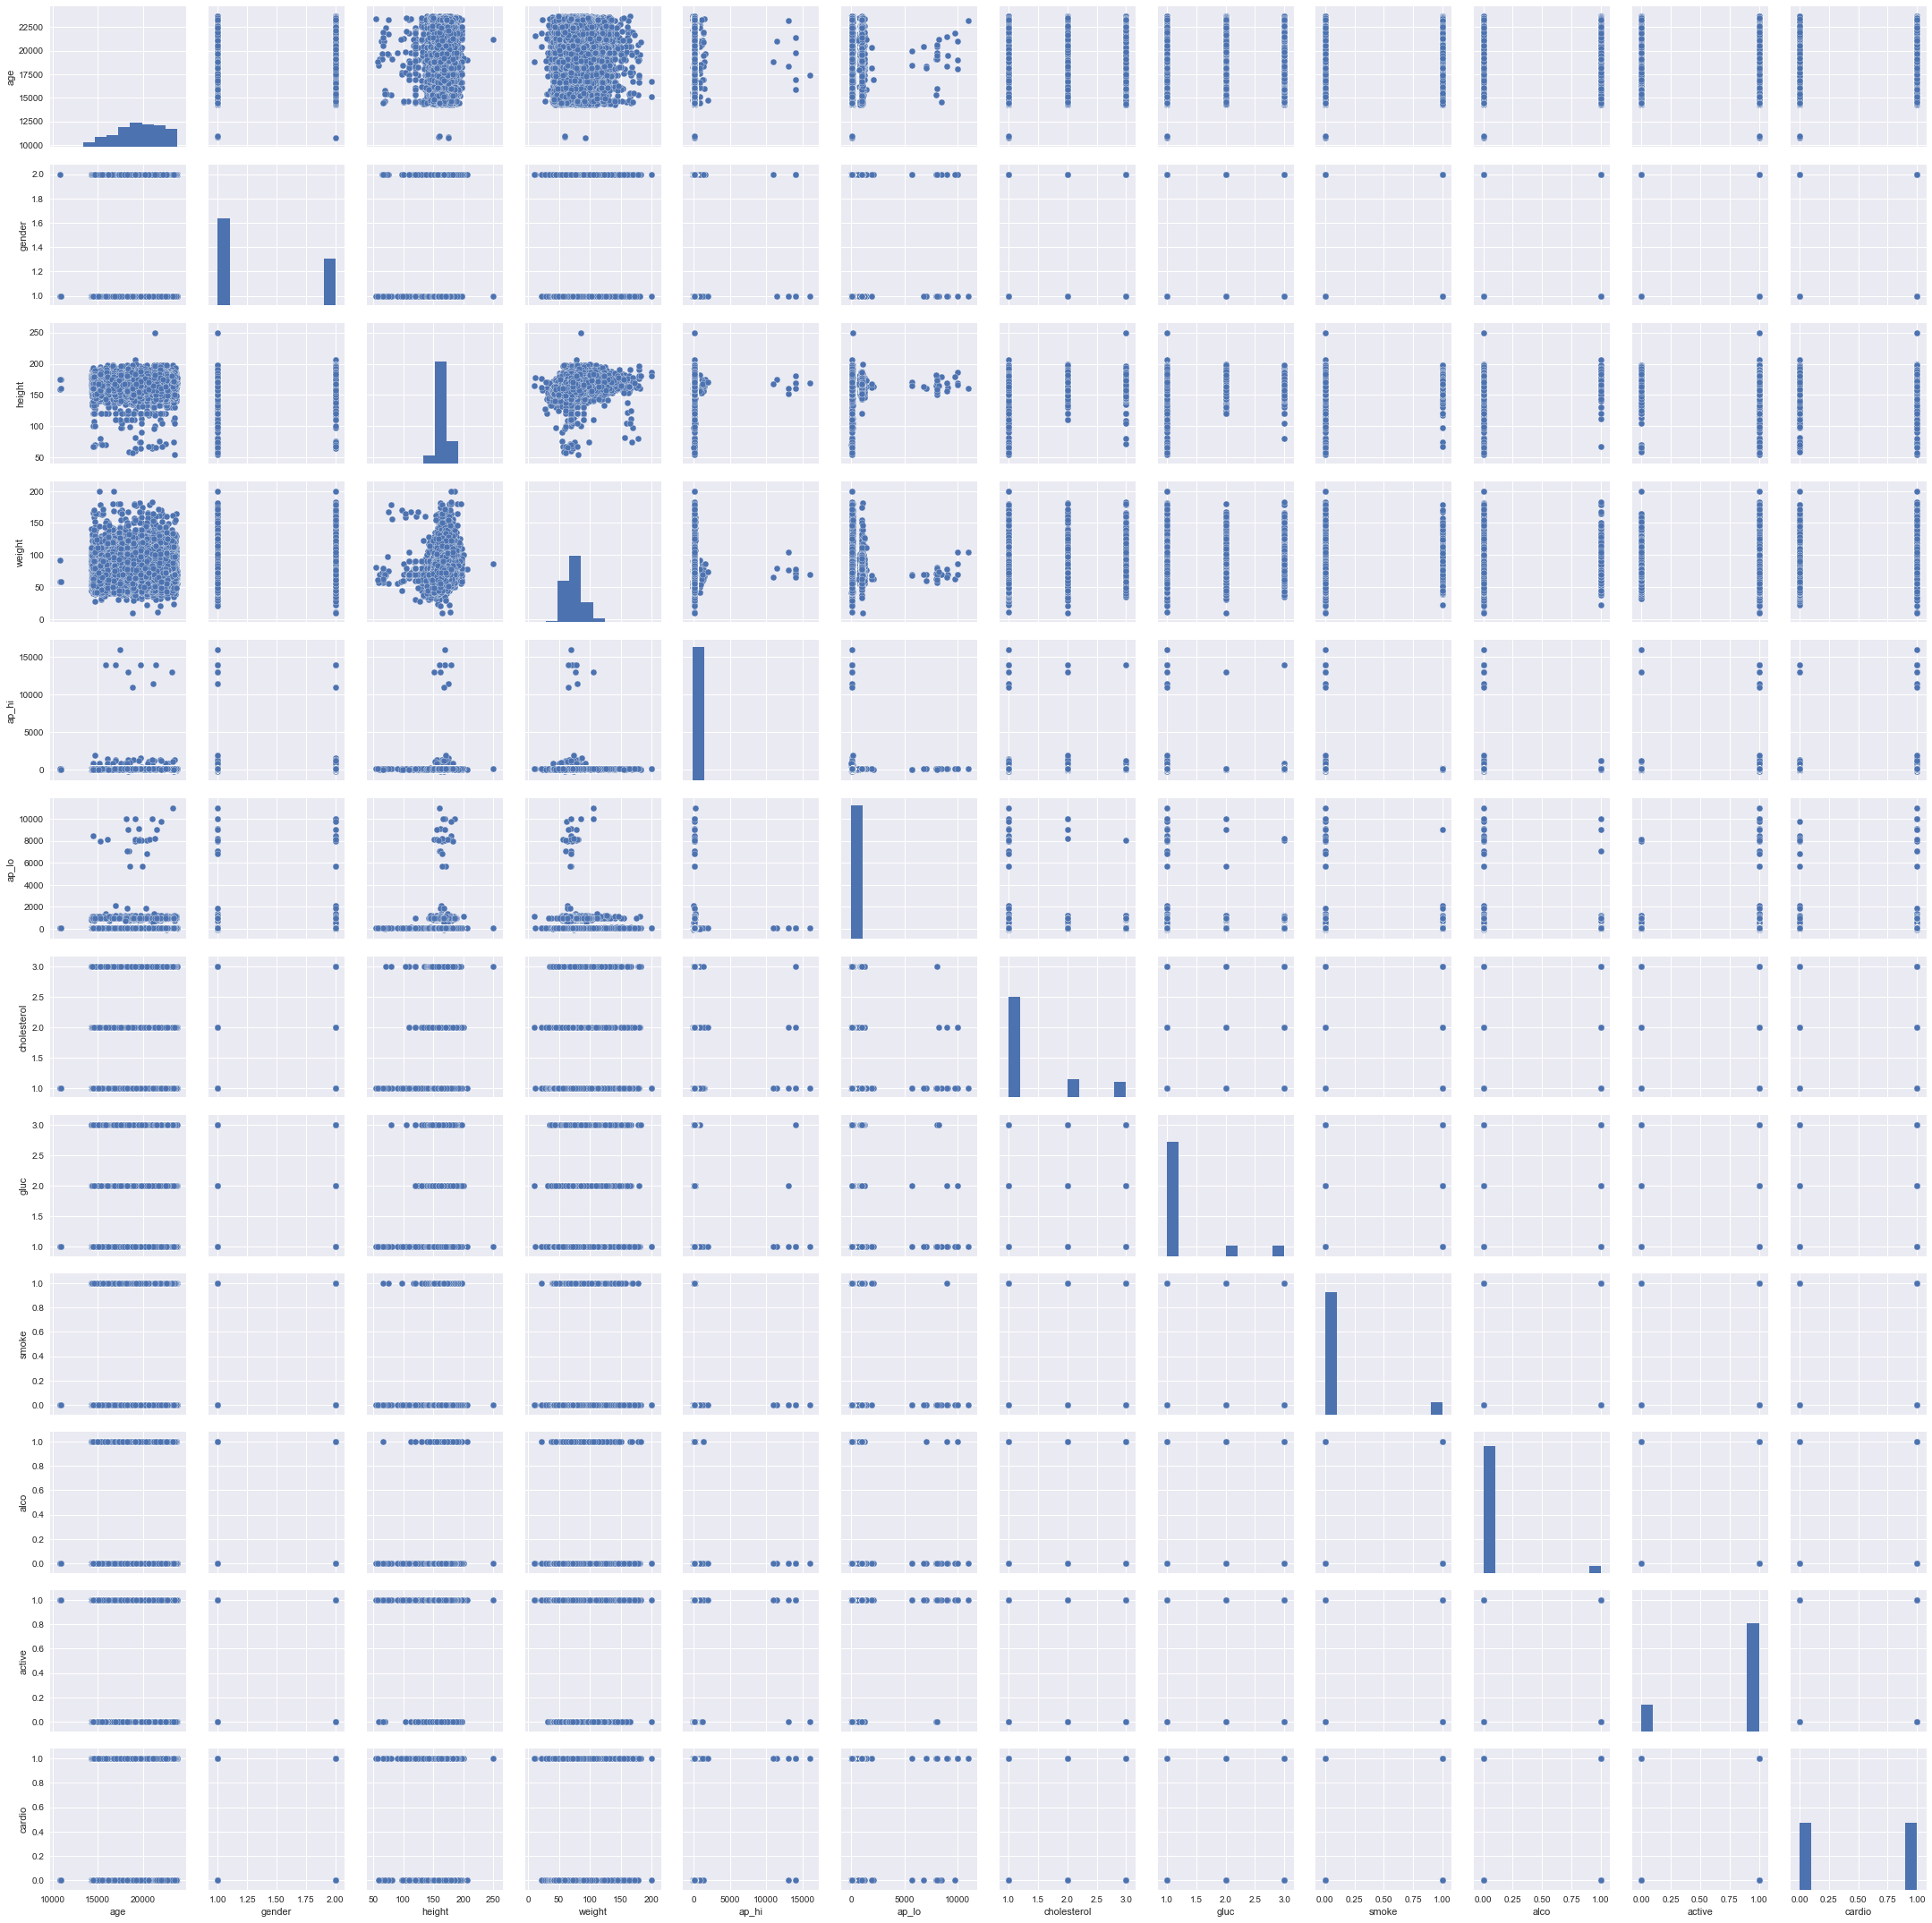

In [14]:
sns.pairplot(dataset)

In [15]:
#err = dataset.loc[(dataset['height'] < dataset['weight'])]

#dataset.loc[err,['height','weight']] = dataset.loc[err,['weight','height']].values


#idx = dataset['height'] < dataset['weight']
#dataset.loc[idx, 'height'] = dataset['weight']
#dataset.loc[idx, 'weight'] = dataset['height']

dataset['ap_hi'] = np.abs(dataset['ap_hi'])
dataset['ap_lo'] = np.abs(dataset['ap_lo'])
dataset['age'] = dataset['age']/365.25
dataset['age'] = np.around(dataset['age'])

datasetTest['ap_hi'] = np.abs(datasetTest['ap_hi'])
datasetTest['ap_lo'] = np.abs(datasetTest['ap_lo'])
datasetTest['age'] = datasetTest['age']/365.25
datasetTest['age'] = np.around(datasetTest['age'])


In [16]:
#idx = dataset['ap_hi'] < dataset['ap_lo']
#dataset.loc[idx, 'ap_hi'] = dataset['ap_lo']
#dataset.loc[idx, 'ap_lo'] = dataset['ap_hi']

#idx1 = dataset['ap_hi'] < 90
#dataset.loc[idx1, 'ap_hi'] = np.mean(dataset['ap_hi'])
#idx2 = dataset['ap_lo'] < 60
#dataset.loc[idx2, 'ap_lo'] = np.mean(dataset['ap_lo'])
#idx3 = dataset['ap_hi'] > 300
#dataset.loc[idx3, 'ap_hi'] = np.mean(dataset['ap_hi'])
#idx4 = dataset['ap_lo'] > 300
#dataset.loc[idx4, 'ap_lo'] = np.mean(dataset['ap_lo'])


#idxt = datasetTest['ap_hi'] < datasetTest['ap_lo']
#datasetTest.loc[idx, 'ap_hi'] = datasetTest['ap_lo']
#datasetTest.loc[idx, 'ap_lo'] = datasetTest['ap_hi']

#idx1t = datasetTest['ap_hi'] < 90
#datasetTest.loc[idx1t, 'ap_hi'] = np.mean(datasetTest['ap_hi'])
#idx2t = datasetTest['ap_lo'] < 60
#datasetTest.loc[idx2t, 'ap_lo'] = np.mean(datasetTest['ap_lo'])
#idx3t = datasetTest['ap_hi'] > 300
#datasetTest.loc[idx3t, 'ap_hi'] = np.mean(datasetTest['ap_hi'])
#idx4t = datasetTest['ap_lo'] > 300
#datasetTest.loc[idx4t, 'ap_lo'] = np.mean(datasetTest['ap_lo'])

In [17]:
#BMI = (Weight in Kilograms / (Height in Meters x Height in Meters))

dataset['heightm'] = dataset['height']/100
dataset['BMI'] = dataset['weight']/(dataset['heightm']*dataset['heightm'])
dataset['BMI'] = np.around(dataset['BMI'])

datasetTest['heightm'] = datasetTest['height']/100
datasetTest['BMI'] = datasetTest['weight']/(datasetTest['heightm']*datasetTest['heightm'])
datasetTest['BMI'] = np.around(datasetTest['BMI'])

In [18]:
dataset.describe()

age        gender        height        weight         ap_hi  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean      53.303157      1.349571    164.359229     74.205690    128.841429   
std        6.760171      0.476838      8.210126     14.395757    153.991223   
min       30.000000      1.000000     55.000000     10.000000      1.000000   
25%       48.000000      1.000000    159.000000     65.000000    120.000000   
50%       54.000000      1.000000    165.000000     72.000000    120.000000   
75%       58.000000      2.000000    170.000000     82.000000    140.000000   
max       65.000000      2.000000    250.000000    200.000000  16020.000000   

              ap_lo   cholesterol          gluc         smoke          alco  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean      96.632414      1.366871      1.226457      0.088129      0.053771   
std      188.471505      0.680250      0.572270      0.283484      0.225568   
min        0.000000      1.000000      1.000000      0.000000      0.000000   
25%       80.000000      1.000000      1.000000      0.000000      0.000000   
50%       80.000000      1.000000      1.000000      0.000000      0.000000   
75%       90.000000      2.000000      1.000000      0.000000      0.000000   
max    11000.000000      3.000000      3.000000      1.000000      1.000000   

             active        cardio       heightm           BMI  
count  70000.000000  70000.000000  70000.000000  70000.000000  
mean       0.803729      0.499700      1.643592     27.548886  
std        0.397179      0.500003      0.082101      6.099019  
min        0.000000      0.000000      0.550000      3.000000  
25%        1.000000      0.000000      1.590000     24.000000  
50%        1.000000      0.000000      1.650000     26.000000  
75%        1.000000      1.000000      1.700000     30.000000  
max        1.000000      1.000000      2.500000    299.000000

In [19]:
print(datasetTest.loc[datasetTest['ap_hi'] > 300])

        age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
303    62.0       2     170    74.0    400     60            1     1      0   
1685   42.0       1     147    53.0    907     70            1     1      0   
5176   56.0       1     157    85.0  12008     80            1     1      0   
6958   50.0       1     166    64.0    957     70            1     1      0   
7463   56.0       1     168    56.0    906     60            2     1      0   
7755   52.0       1     170    64.0  14020     90            1     1      0   
8852   60.0       1     165    58.0  16020     70            1     1      0   
9262   44.0       2     180    70.0    906     60            1     1      0   
9399   45.0       1     151    56.0  14020     90            1     1      0   
10566  51.0       1     160    86.0   1502     80            2     1      0   
13449  54.0       2     165    89.0   1400     90            1     1      0   
13563  60.0       2     174    60.0  14020     80   

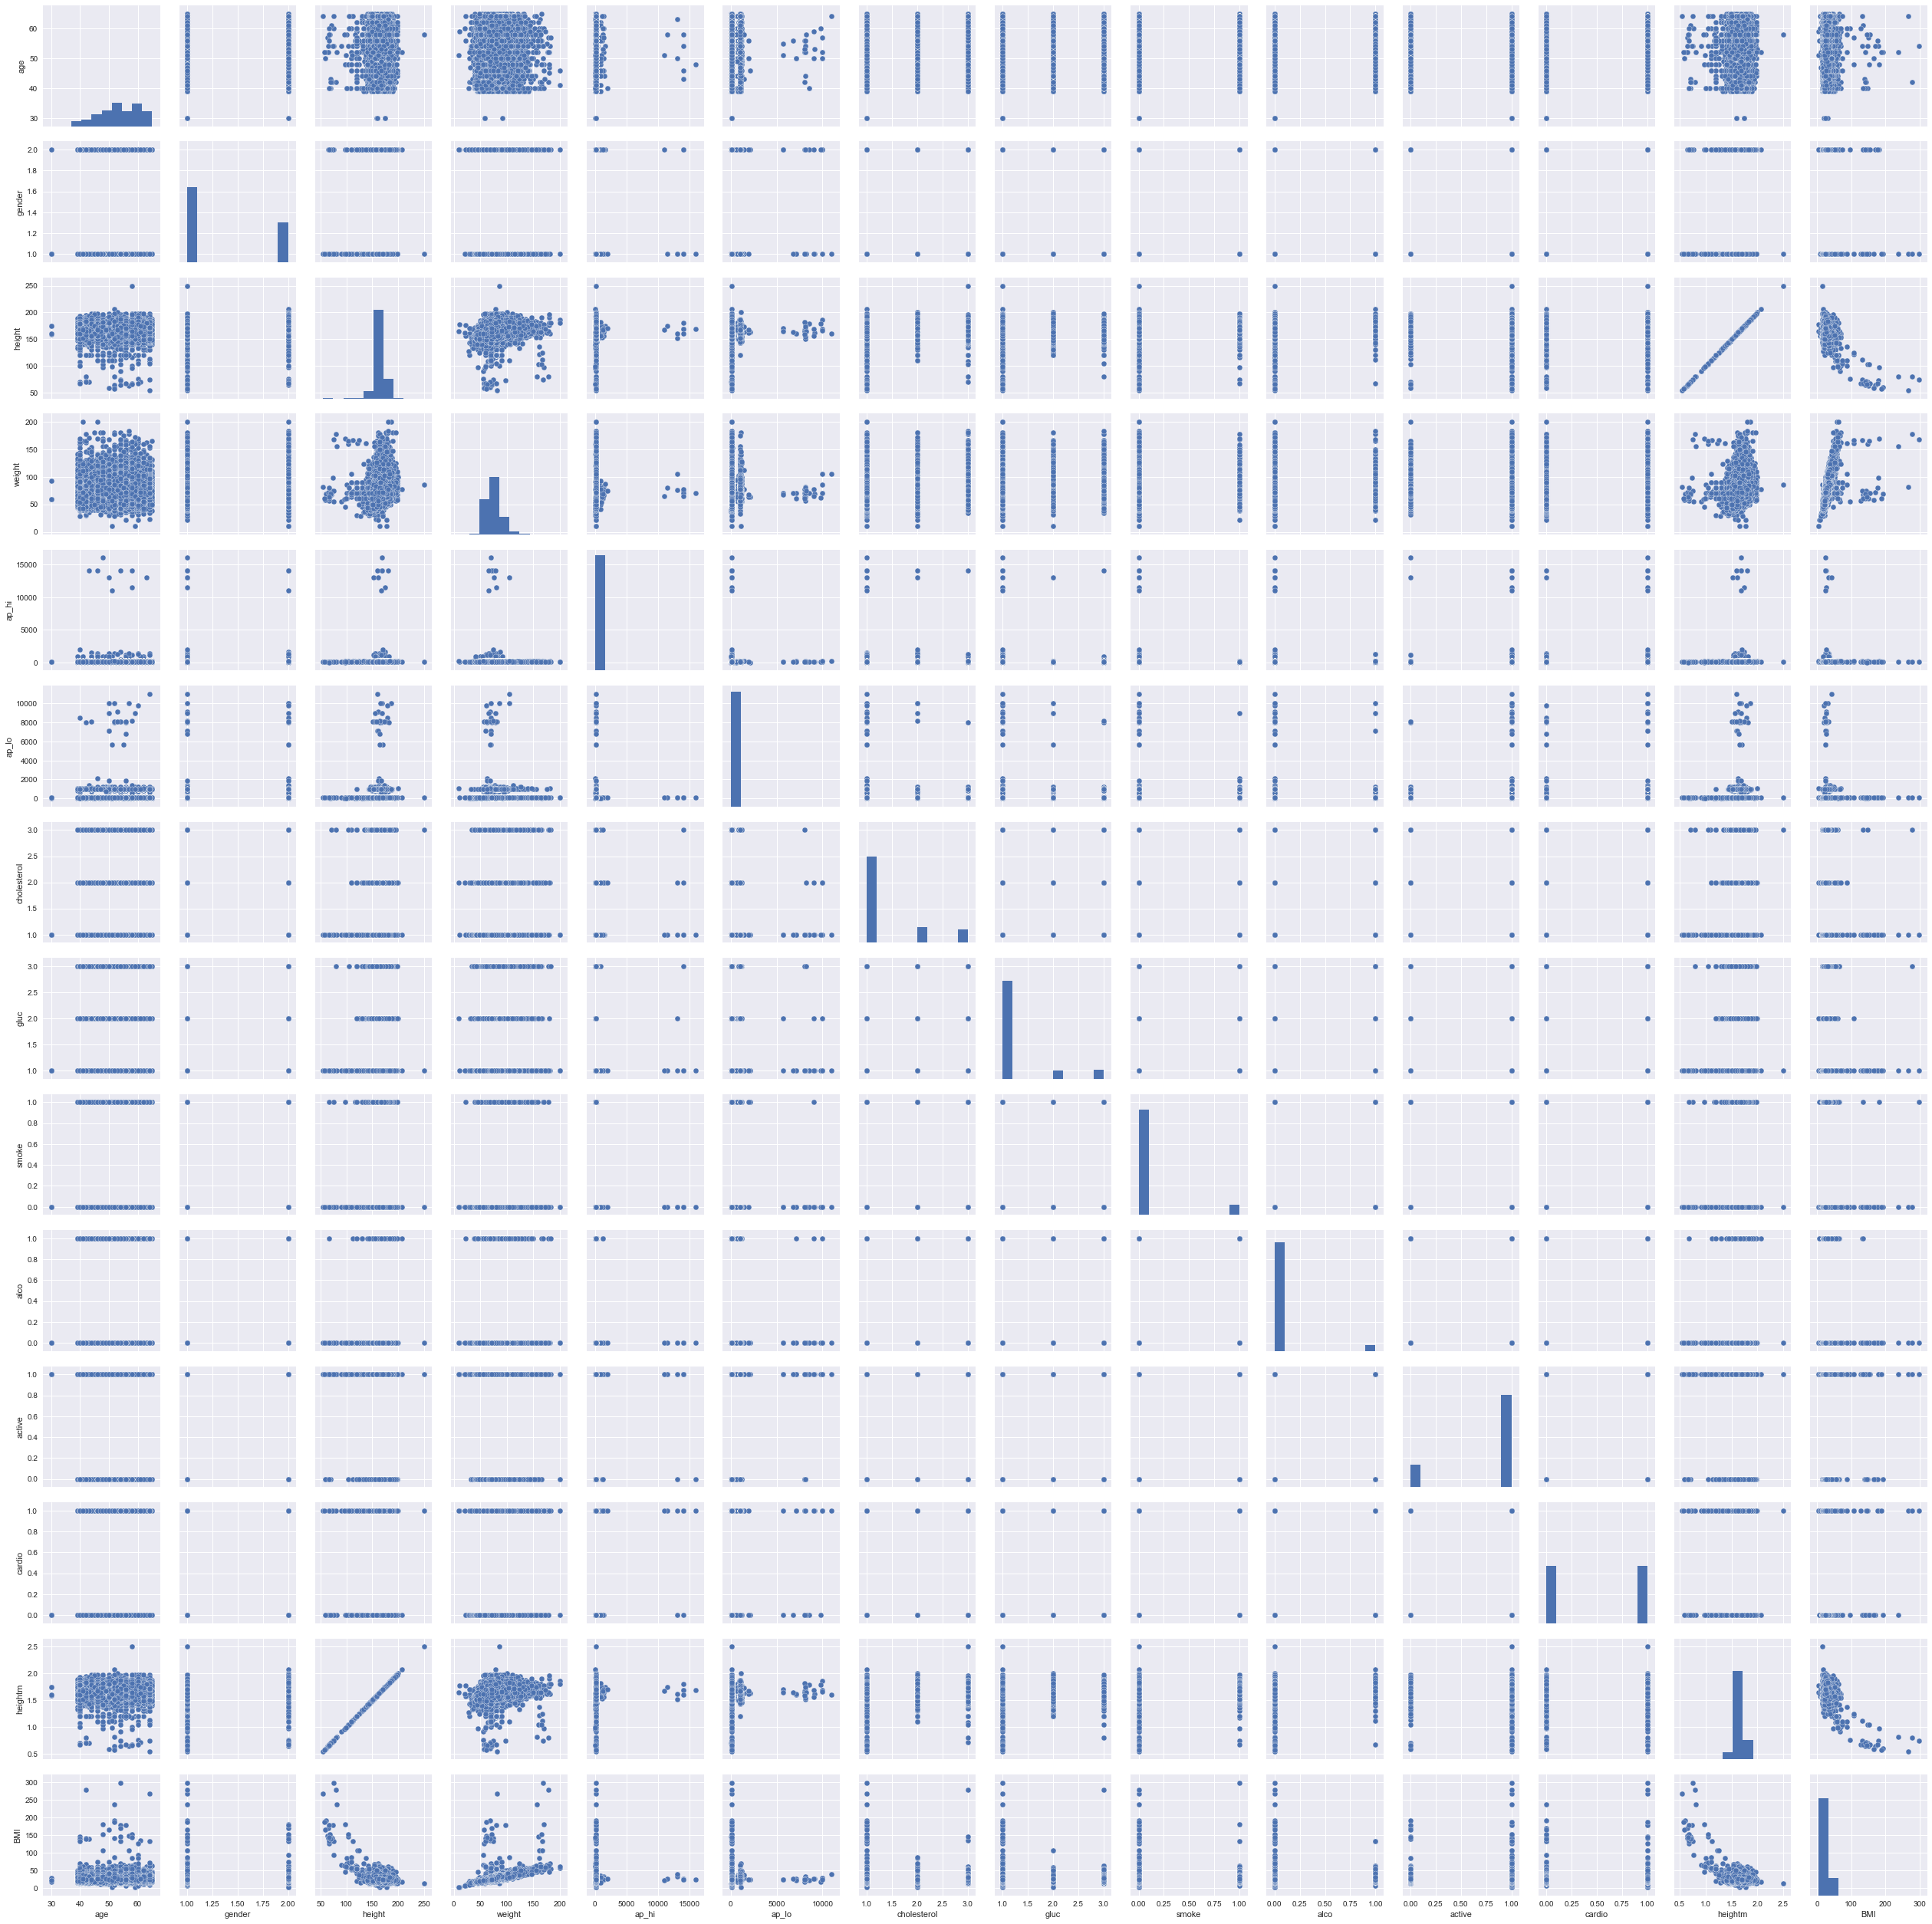

In [20]:
sns.pairplot(dataset)

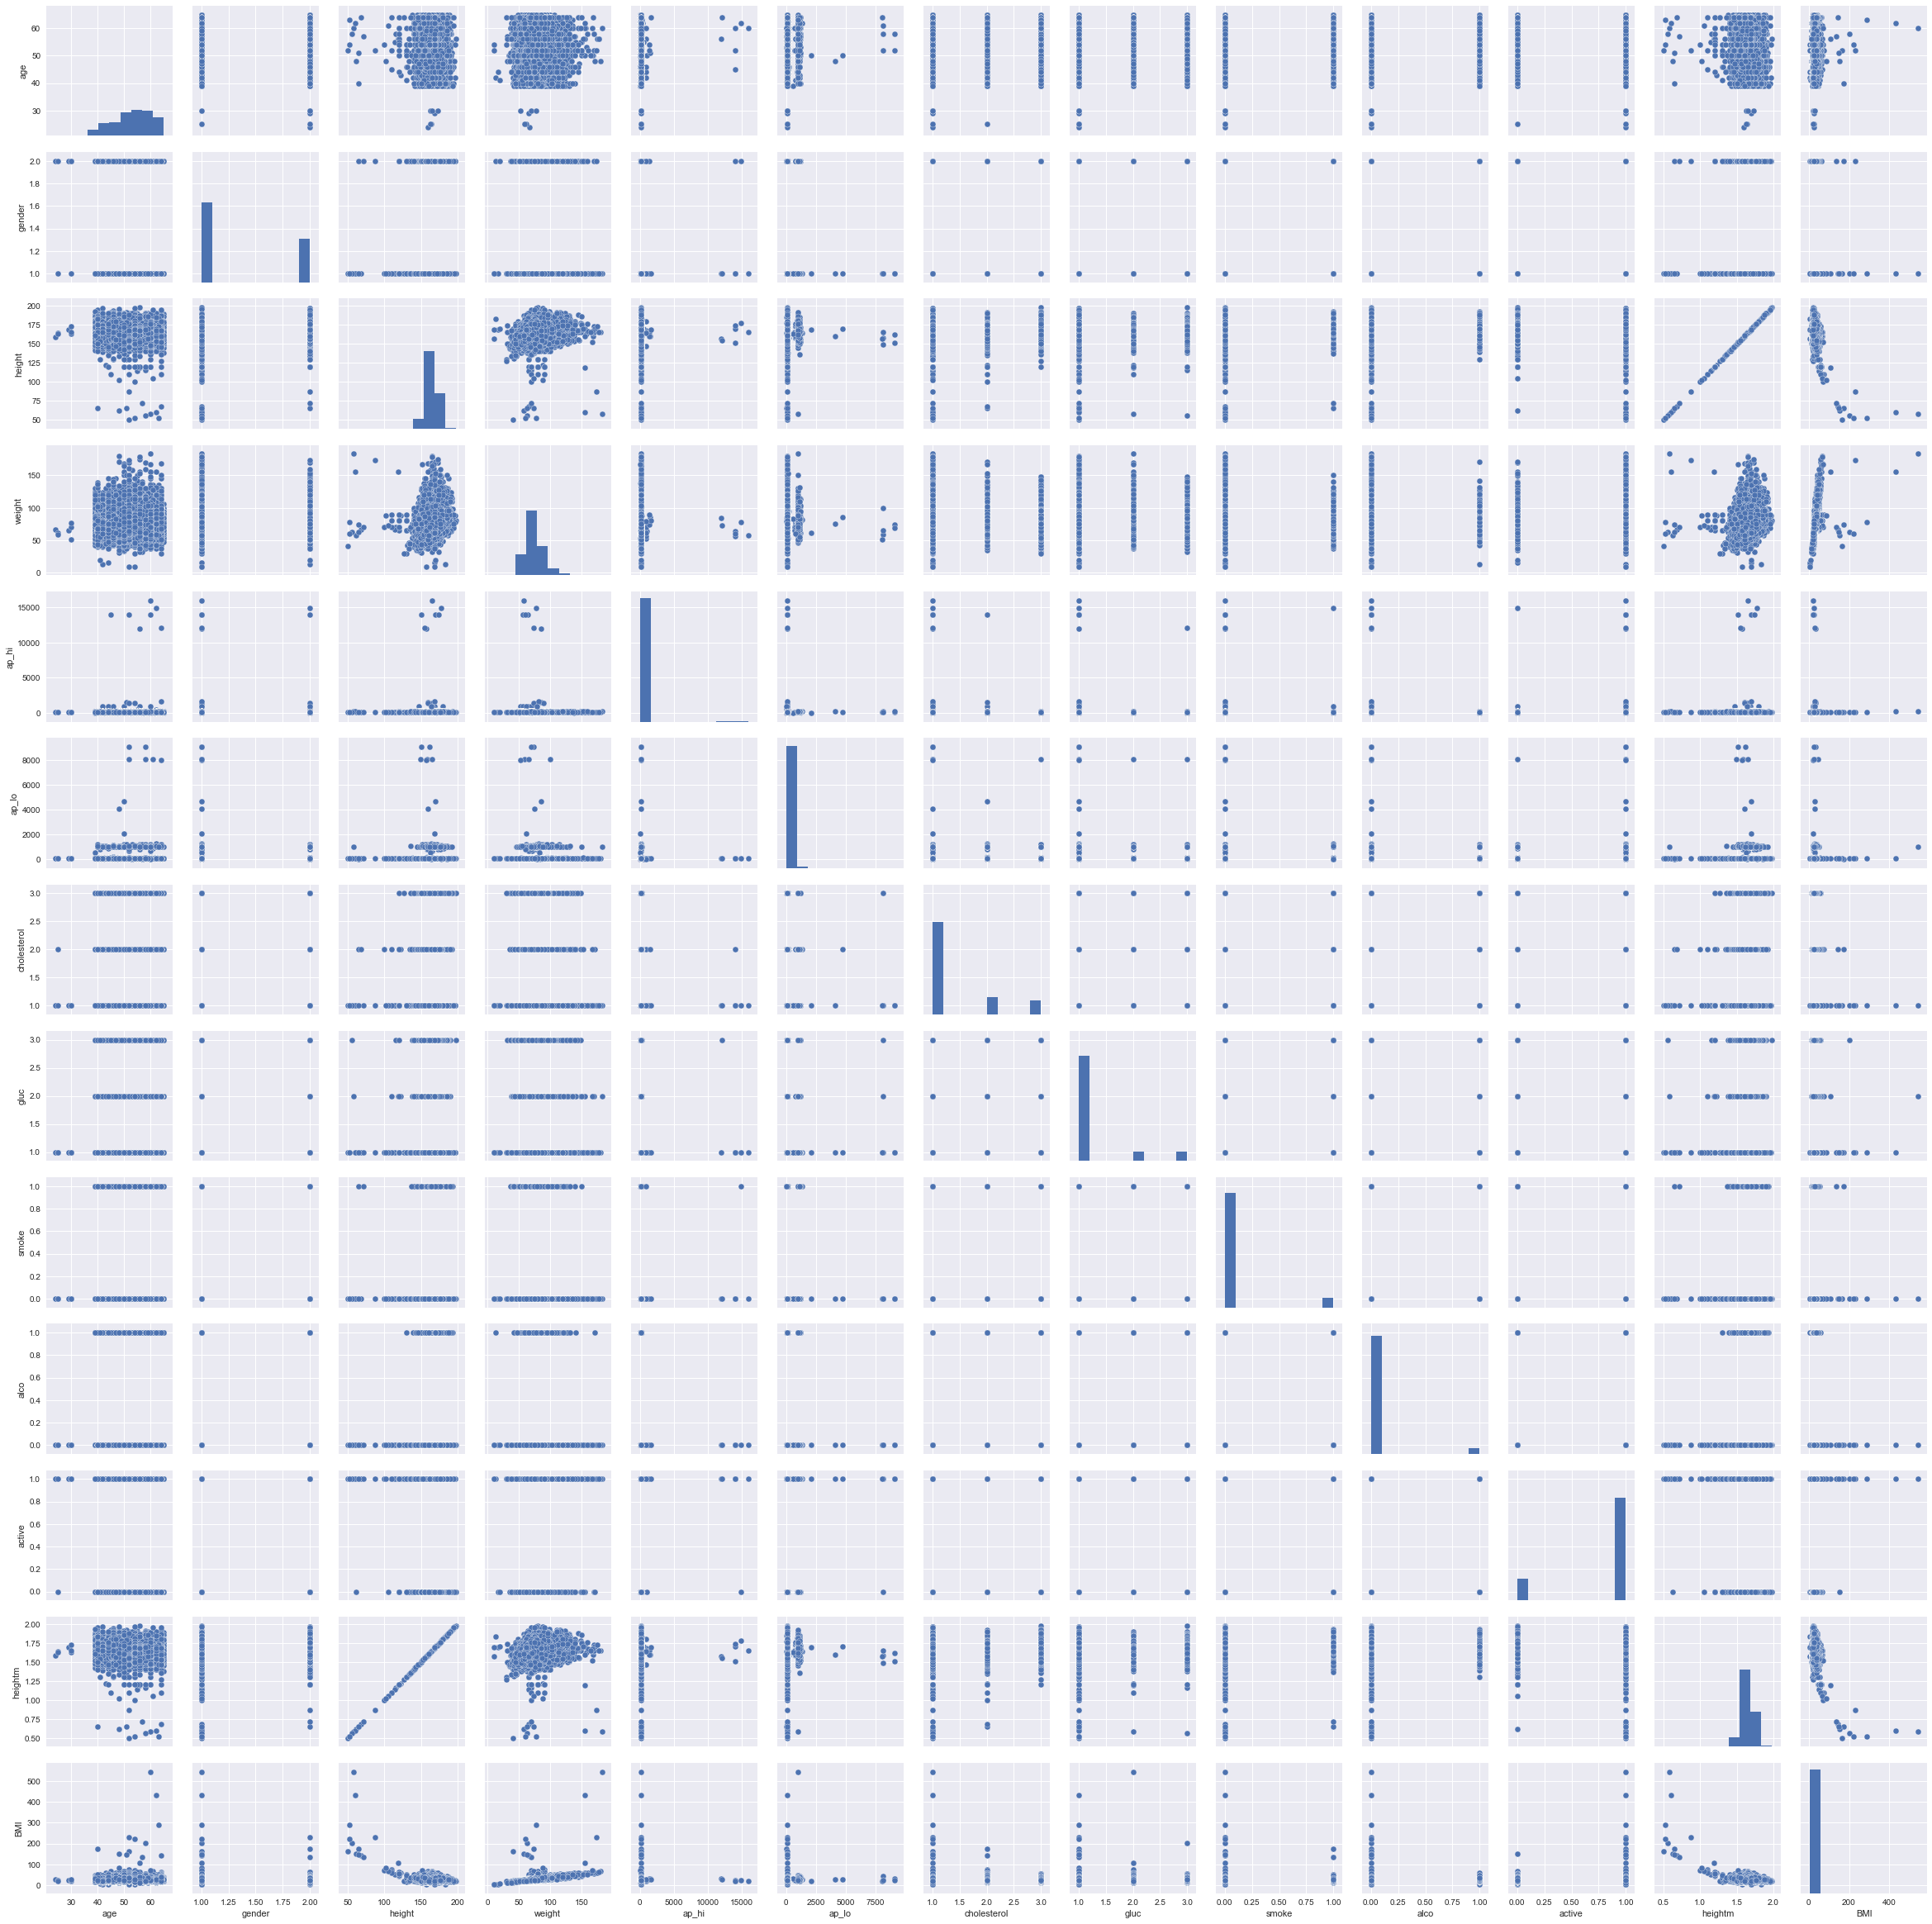

In [21]:
sns.pairplot(datasetTest)

In [22]:
idxrow = dataset['height'] > 240
dataset.loc[idxrow, 'height'] = 150

dataset.set_value(29488, 'weight', 52)
dataset.set_value(57858, 'weight', 100)
dataset.set_value(33817, 'weight', 110)
dataset.set_value(60188, 'weight', 91)
dataset.set_value(26806, 'weight', 53)
dataset.set_value(60699, 'weight', 59)
dataset.set_value(18559, 'weight', 80)
dataset.set_value(16906, 'weight', 81)
dataset.set_value(58200, 'weight', 85)
dataset.set_value(9487, 'weight', 90)
dataset.set_value(12920, 'weight', 95)
dataset.set_value(55852, 'weight', 84)
dataset.set_value(224, 'height', 176)

dataset.set_value(2458, 'weight', 65)
dataset.set_value(6153, 'weight', 61)
dataset.set_value(8171, 'weight', 97)
dataset.set_value(8171, 'height', 170)
dataset.set_value(12435, 'weight', 101)
dataset.set_value(12770, 'weight', 68)
dataset.set_value(15366, 'weight', 67)
dataset.set_value(18952, 'weight', 63)
dataset.set_value(20028, 'weight', 67)
dataset.set_value(20092, 'weight', 78)
dataset.set_value(23913, 'weight', 56)
dataset.set_value(27384, 'weight', 80)
dataset.set_value(27384, 'height', 178)
dataset.set_value(28737, 'weight', 91)
dataset.set_value(36780, 'weight', 101)
dataset.set_value(37590, 'weight', 75)
dataset.set_value(40712, 'weight', 62)
dataset.set_value(45358, 'weight', 104)
dataset.set_value(45358, 'height', 159)
dataset.set_value(59625, 'weight', 65)
dataset.set_value(61788, 'weight', 78)
dataset.set_value(63687, 'weight', 55)
dataset.set_value(67866, 'weight', 83)

dataset.set_value(3420, 'height', 170)
dataset.set_value(7598, 'height', 172)
dataset.set_value(11230, 'height', 170)
dataset.set_value(13265, 'height', 171)
dataset.set_value(14323, 'height', 167)
dataset.set_value(15167, 'height', 170)
dataset.set_value(16699, 'height', 198)
dataset.set_value(17074, 'height', 160)
dataset.set_value(22542, 'height', 168)
dataset.set_value(22723, 'height', 181)
dataset.set_value(27603, 'height', 164)
dataset.set_value(28737, 'height', 155)
dataset.set_value(28897, 'height', 170)
dataset.set_value(29157, 'height', 169)
dataset.set_value(32098, 'height', 174)
dataset.set_value(33607, 'height', 172)
dataset.set_value(37388, 'height', 165)
dataset.set_value(44490, 'height', 165)
dataset.set_value(46319, 'height', 171)
dataset.set_value(47352, 'height', 175)
dataset.set_value(50789, 'height', 167)
dataset.set_value(51459, 'height', 170)
dataset.set_value(53344, 'height', 180)
dataset.set_value(64115, 'height', 159)
dataset.set_value(64454, 'height', 166)
dataset.set_value(64787, 'height', 165)
dataset.set_value(66479, 'height', 190)
dataset.set_value(66643, 'height', 161)
dataset.set_value(67866, 'height', 163)
dataset.set_value(389, 'weight', 69)
dataset.set_value(435, 'weight', 100)
dataset.set_value(2441, 'weight', 77)
dataset.set_value(3313, 'weight', 55)
dataset.set_value(3413, 'weight', 59)
dataset.set_value(4743, 'weight', 80)
dataset.set_value(18648, 'weight', 68)
dataset.set_value(19579, 'weight', 62)
dataset.set_value(41844, 'weight', 64)
dataset.set_value(50413, 'weight', 100)
dataset.set_value(56177, 'weight', 71)
dataset.set_value(58808, 'weight', 70)
dataset.set_value(60592, 'weight', 80)
dataset.set_value(61285, 'weight', 83)
dataset.set_value(63937, 'weight', 64)
dataset.set_value(64661, 'weight', 72)


dataset.set_value(8677, 'height', 179)
dataset.set_value(14675, 'weight', 53)
dataset.set_value(24006, 'height', 160)
dataset.set_value(24006, 'weight', 60)
dataset.set_value(39543, 'height', 168)
dataset.set_value(42445, 'height', 168)
dataset.set_value(42445, 'weight', 65)
dataset.set_value(46573, 'weight', 68)
dataset.set_value(51909, 'weight', 90)
dataset.set_value(56022, 'height', 169)
dataset.set_value(57369, 'height', 190)
dataset.set_value(65302, 'height', 169)


dataset.set_value(23129, 'weight', 56)
dataset.set_value(23913, 'height', 161)
dataset.set_value(28448, 'weight', 47)
dataset.set_value(12770, 'height', 174)
dataset.set_value(59625, 'height', 164)


dataset.set_value(58868, 'height', 160)
dataset.set_value(59625, 'height', 164)

dataset.set_value(1876, 'ap_hi', 90)
dataset.set_value(2014, 'ap_hi', 90)
dataset.set_value(2014, 'ap_lo', 60)
dataset.set_value(4817, 'ap_hi', 90)
dataset.set_value(7763, 'ap_hi', 150)
dataset.set_value(8915, 'ap_hi', 140)
dataset.set_value(9557, 'ap_hi', 140)
dataset.set_value(13895, 'ap_hi', 150)
dataset.set_value(17713, 'ap_hi', 90)
dataset.set_value(23867, 'ap_lo', 60)
dataset.set_value(23867, 'ap_hi', 90)
dataset.set_value(25464, 'ap_hi', 140)
dataset.set_value(25519, 'ap_hi', 140)
dataset.set_value(25780, 'ap_hi', 140)
dataset.set_value(28147, 'ap_hi', 160)
dataset.set_value(29665, 'ap_hi', 90)
dataset.set_value(31783, 'ap_hi', 90)
dataset.set_value(31783, 'ap_lo', 70)
dataset.set_value(36894, 'ap_hi', 130)
dataset.set_value(40330, 'ap_hi', 130)
dataset.set_value(40330, 'ap_lo', 90)
dataset.set_value(40831, 'ap_hi', 140)
dataset.set_value(40852, 'ap_hi', 160)
dataset.set_value(41095, 'ap_hi', 120)
dataset.set_value(41505, 'ap_hi', 80)
dataset.set_value(41505, 'ap_lo', 60)
dataset.set_value(42397, 'ap_hi', 90)
dataset.set_value(42397, 'ap_lo', 60)
dataset.set_value(42658, 'ap_hi', 90)
dataset.set_value(43133, 'ap_hi', 140)
dataset.set_value(43208, 'ap_hi', 140)
dataset.set_value(43504, 'ap_hi', 130)
dataset.set_value(46912, 'ap_hi', 140)
dataset.set_value(47253, 'ap_hi', 140)
dataset.set_value(48795, 'ap_hi', 140)
dataset.set_value(50836, 'ap_hi', 140)
dataset.set_value(51438, 'ap_hi', 110)
dataset.set_value(53982, 'ap_hi', 90)
dataset.set_value(55459, 'ap_hi', 130)
dataset.set_value(55847, 'ap_hi', 130)
dataset.set_value(57291, 'ap_hi', 130)
dataset.set_value(57918, 'ap_hi', 110)
dataset.set_value(63996, 'ap_hi', 120)
dataset.set_value(64911, 'ap_hi', 90)
dataset.set_value(68663, 'ap_hi', 90)
dataset.set_value(68663, 'ap_lo', 60)
dataset.set_value(69370, 'ap_hi', 200)
dataset.set_value(473, 'ap_lo', 100)
dataset.set_value(6695, 'ap_hi', 170)
dataset.set_value(6695, 'ap_lo', 100)
dataset.set_value(42334, 'ap_hi', 110)
dataset.set_value(42334, 'ap_lo', 80)
dataset.set_value(8757, 'ap_hi', 120)
dataset.set_value(8757, 'ap_lo', 80)
dataset.set_value(64409, 'ap_hi', 135)
dataset.set_value(64409, 'ap_lo', 85)


idxap = dataset['ap_lo'] == 1000
dataset.loc[idxap, 'ap_lo'] = 100

idxap1 = dataset['ap_lo'] == 1001
dataset.loc[idxap1, 'ap_lo'] = 100

idxap2 = dataset['ap_lo'] == 1100
dataset.loc[idxap2, 'ap_lo'] = 110

idxap3 = dataset['ap_lo'] == 10000
dataset.loc[idxap3, 'ap_lo'] = 100

idxap4 = dataset['ap_lo'] == 1200
dataset.loc[idxap4, 'ap_lo'] = 120

idxap5 = dataset['ap_lo'] == 11000
dataset.loc[idxap5, 'ap_lo'] = 110

idxap6 = dataset['ap_lo'] == 1110
dataset.loc[idxap6, 'ap_lo'] = 110

idxap7 = dataset['ap_lo'] == 1400
dataset.loc[idxap7, 'ap_lo'] = 140

idxap8 = dataset['ap_lo'] == 1900
dataset.loc[idxap8, 'ap_lo'] = 90

idxap9 = dataset['ap_lo'] == 9011
dataset.loc[idxap9, 'ap_lo'] = 90

idxap10 = dataset['ap_lo'] == 9100
dataset.loc[idxap10, 'ap_lo'] = 90

idxap11 = dataset['ap_lo'] == 8100
dataset.loc[idxap11, 'ap_lo'] = 80

idxap12 = dataset['ap_lo'] == 8000
dataset.loc[idxap12, 'ap_lo'] = 80

idxap13 = dataset['ap_lo'] == 8099
dataset.loc[idxap13, 'ap_lo'] = 80

idxap14 = dataset['ap_lo'] == 8044
dataset.loc[idxap14, 'ap_lo'] = 80

idxap15 = dataset['ap_lo'] == 9800
dataset.loc[idxap15, 'ap_lo'] = 90

idxap16 = dataset['ap_lo'] == 8077
dataset.loc[idxap16, 'ap_lo'] = 80

idxap17 = dataset['ap_lo'] == 8500
dataset.loc[idxap17, 'ap_lo'] = 80

idxap18 = dataset['ap_lo'] == 8200
dataset.loc[idxap18, 'ap_lo'] = 80

idxap19 = dataset['ap_lo'] == 8079
dataset.loc[idxap19, 'ap_lo'] = 80


idxap20 = dataset['ap_lo'] == 7100
dataset.loc[idxap20, 'ap_lo'] = 70

idxap21 = dataset['ap_lo'] == 7099
dataset.loc[idxap21, 'ap_lo'] = 70

idxap22 = dataset['ap_lo'] == 1140
dataset.loc[idxap22, 'ap_lo'] = 140

idxap23 = dataset['ap_lo'] == 1008
dataset.loc[idxap23, 'ap_lo'] = 100

idxap24 = dataset['ap_lo'] == 1007
dataset.loc[idxap24, 'ap_lo'] = 100

idxap25 = dataset['ap_lo'] == 1120
dataset.loc[idxap25, 'ap_lo'] = 110

idxap26 = dataset['ap_lo'] == 1177
dataset.loc[idxap26, 'ap_lo'] = 110

idxap27 = dataset['ap_lo'] == 1044
dataset.loc[idxap27, 'ap_lo'] = 100

idxap28 = dataset['ap_lo'] == 1022
dataset.loc[idxap28, 'ap_lo'] = 100

idxap29 = dataset['ap_lo'] == 1011
dataset.loc[idxap29, 'ap_lo'] = 100

idxap30 = dataset['ap_lo'] == 1088
dataset.loc[idxap30, 'ap_lo'] = 100

idxap31 = dataset['ap_lo'] == 1077
dataset.loc[idxap31, 'ap_lo'] = 100

idxap32 = dataset['ap_lo'] == 1002
dataset.loc[idxap32, 'ap_lo'] = 100

idxap33 = dataset['ap_lo'] == 1003
dataset.loc[idxap33, 'ap_lo'] = 100

idxap34 = dataset['ap_lo'] == 1125
dataset.loc[idxap34, 'ap_lo'] = 110

idxap35 = dataset['ap_lo'] == 1101
dataset.loc[idxap35, 'ap_lo'] = 110

idxap36 = dataset['ap_lo'] == 1111
dataset.loc[idxap36, 'ap_lo'] = 110

idxap37 = dataset['ap_lo'] == 1139
dataset.loc[idxap37, 'ap_lo'] = 110

idxap38 = dataset['ap_lo'] == 5700
dataset.loc[idxap38, 'ap_lo'] = 70

idxap39 = dataset['ap_lo'] == 1211
dataset.loc[idxap39, 'ap_lo'] = 120

idxap40 = dataset['ap_lo'] == 6800
dataset.loc[idxap40, 'ap_lo'] = 80

idxap41 = dataset['ap_lo'] == 802
dataset.loc[idxap41, 'ap_lo'] = 80

idxap42 = dataset['ap_lo'] == 800
dataset.loc[idxap42, 'ap_lo'] = 80

idxap43 = dataset['ap_lo'] == 902
dataset.loc[idxap43, 'ap_lo'] = 90

idxap44 = dataset['ap_lo'] == 801
dataset.loc[idxap44, 'ap_lo'] = 80

idxap45 = dataset['ap_lo'] == 803
dataset.loc[idxap45, 'ap_lo'] = 80

idxap46 = dataset['ap_lo'] == 809
dataset.loc[idxap46, 'ap_lo'] = 80

idxap47 = dataset['ap_lo'] == 850
dataset.loc[idxap47, 'ap_lo'] = 80

idxap48 = dataset['ap_lo'] == 880
dataset.loc[idxap48, 'ap_lo'] = 80

idxap49 = dataset['ap_lo'] == 870
dataset.loc[idxap49, 'ap_lo'] = 80

idxap50 = dataset['ap_lo'] == 810
dataset.loc[idxap50, 'ap_lo'] = 80

idxap51 = dataset['ap_lo'] == 820
dataset.loc[idxap51, 'ap_lo'] = 80

idxap52 = dataset['ap_lo'] == 708
dataset.loc[idxap52, 'ap_lo'] = 70

idxap53 = dataset['ap_lo'] == 709
dataset.loc[idxap53, 'ap_lo'] = 70

idxap54 = dataset['ap_lo'] == 710
dataset.loc[idxap54, 'ap_lo'] = 70

idxap55 = dataset['ap_lo'] == 700
dataset.loc[idxap55, 'ap_lo'] = 70

idxap56 = dataset['ap_lo'] == 900
dataset.loc[idxap56, 'ap_lo'] = 90

idxap57 = dataset['ap_lo'] == 910
dataset.loc[idxap57, 'ap_lo'] = 90

idxap58 = dataset['ap_lo'] == 901
dataset.loc[idxap58, 'ap_lo'] = 90

idxap59 = dataset['ap_lo'] == 602
dataset.loc[idxap59, 'ap_lo'] = 60

idxap60 = dataset['ap_hi'] == 906
dataset.loc[idxap60, 'ap_hi'] = 90

idxap61 = dataset['ap_hi'] == 14200
dataset.loc[idxap61, 'ap_hi'] = 140

idxap61 = dataset['ap_hi'] == 14900
dataset.loc[idxap61, 'ap_hi'] = 140

idxap62 = dataset['ap_hi'] == 14020
dataset.loc[idxap62, 'ap_hi'] = 140

idxap63 = dataset['ap_hi'] == 12008
dataset.loc[idxap63, 'ap_hi'] = 120

idxap64 = dataset['ap_hi'] == 907
dataset.loc[idxap64, 'ap_hi'] = 90

idxap65 = dataset['ap_hi'] == 1502
dataset.loc[idxap65, 'ap_hi'] = 150

idxap66 = dataset['ap_hi'] == 957
dataset.loc[idxap66, 'ap_hi'] = 90

idxap67 = dataset['ap_hi'] == 1400
dataset.loc[idxap67, 'ap_hi'] = 140

idxap68 = dataset['ap_hi'] == 509
dataset.loc[idxap68, 'ap_hi'] = 90

idxap69 = dataset['ap_hi'] == 12080
dataset.loc[idxap69, 'ap_hi'] = 120

idxap70 = dataset['ap_lo'] == 0
dataset.loc[idxap70, 'ap_lo'] = 60

idxap70 = dataset['ap_lo'] == 0
dataset.loc[idxap70, 'ap_lo'] = 60

idxap71 = dataset['ap_hi'] == 16020
dataset.loc[idxap71, 'ap_hi'] = 160

idxap72 = dataset['ap_hi'] == 1407
dataset.loc[idxap72, 'ap_hi'] = 140

idxap73 = dataset['ap_hi'] == 1608
dataset.loc[idxap73, 'ap_hi'] = 160

idxap74 = dataset['ap_hi'] == 400
dataset.loc[idxap74, 'ap_hi'] = 90

idxap75 = dataset['ap_lo'] == 1130
dataset.loc[idxap75, 'ap_lo'] = 110

idxap76 = dataset['ap_lo'] == 701
dataset.loc[idxap76, 'ap_lo'] = 70

idxap77 = dataset['ap_lo'] == 8022
dataset.loc[idxap77, 'ap_lo'] = 80

idxap78 = dataset['ap_lo'] == 4700
dataset.loc[idxap78, 'ap_lo'] = 70


idxap79 = dataset['ap_lo'] == 1099
dataset.loc[idxap79, 'ap_lo'] = 110

idxap80 = dataset['ap_lo'] == 1009
dataset.loc[idxap80, 'ap_lo'] = 100

idxap81 = dataset['ap_lo'] == 4100
dataset.loc[idxap81, 'ap_lo'] = 100

idxap82 = dataset['ap_lo'] == 808
dataset.loc[idxap82, 'ap_lo'] = 80

idxap83 = dataset['ap_lo'] == 1300
dataset.loc[idxap83, 'ap_lo'] = 130

idxap84 = dataset['ap_lo'] == 1004
dataset.loc[idxap84, 'ap_lo'] = 100

idxap85 = dataset['ap_lo'] == 1066
dataset.loc[idxap85, 'ap_lo'] = 100

idxap86 = dataset['ap_lo'] == 7
dataset.loc[idxap86, 'ap_lo'] = 70

idxap87 = dataset['ap_lo'] == 8
dataset.loc[idxap87, 'ap_lo'] = 80

idxap88 = dataset['ap_lo'] == 6
dataset.loc[idxap88, 'ap_lo'] = 60

idxap89 = dataset['ap_lo'] == 30
dataset.loc[idxap89, 'ap_lo'] = 130

idxap90 = dataset['ap_lo'] == 10
dataset.loc[idxap90, 'ap_lo'] = 100

idxap91 = dataset['ap_lo'] == 1
dataset.loc[idxap91, 'ap_lo'] = 100

idxap92 = dataset['ap_lo'] == 9
dataset.loc[idxap92, 'ap_lo'] = 90

idxap93 = dataset['ap_hi'] == 13
dataset.loc[idxap93, 'ap_hi'] = 130

idxap94 = dataset['ap_lo'] == 40
dataset.loc[idxap94, 'ap_lo'] = 90

idxap95 = dataset['ap_lo'] == 20
dataset.loc[idxap95, 'ap_lo'] = 80

In [23]:
#dataset.iloc[29488]

In [24]:
idxapd = datasetTest['ap_lo'] == 1000
datasetTest.loc[idxapd, 'ap_lo'] = 100

idxapd1 = datasetTest['ap_lo'] == 1001
datasetTest.loc[idxapd1, 'ap_lo'] = 100

idxapd2 = datasetTest['ap_lo'] == 1100
datasetTest.loc[idxapd2, 'ap_lo'] = 110

idxapd3 = datasetTest['ap_lo'] == 10000
datasetTest.loc[idxapd3, 'ap_lo'] = 100

idxapd4 = datasetTest['ap_lo'] == 1200
datasetTest.loc[idxapd4, 'ap_lo'] = 120

idxapd5 = datasetTest['ap_lo'] == 11000
datasetTest.loc[idxapd5, 'ap_lo'] = 110

idxapd6 = datasetTest['ap_lo'] == 1110
datasetTest.loc[idxapd6, 'ap_lo'] = 110

idxapd7 = datasetTest['ap_lo'] == 1400
datasetTest.loc[idxapd7, 'ap_lo'] = 140

idxapd8 = datasetTest['ap_lo'] == 1900
datasetTest.loc[idxapd8, 'ap_lo'] = 90

idxapd9 = datasetTest['ap_lo'] == 9011
datasetTest.loc[idxapd9, 'ap_lo'] = 90

idxapd10 = datasetTest['ap_lo'] == 9100
datasetTest.loc[idxapd10, 'ap_lo'] = 90

idxapd11 = datasetTest['ap_lo'] == 8100
datasetTest.loc[idxapd11, 'ap_lo'] = 80

idxapd12 = datasetTest['ap_lo'] == 8000
datasetTest.loc[idxapd12, 'ap_lo'] = 80

idxapd13 = datasetTest['ap_lo'] == 8099
datasetTest.loc[idxapd13, 'ap_lo'] = 80

idxapd14 = datasetTest['ap_lo'] == 8044
datasetTest.loc[idxapd14, 'ap_lo'] = 80

idxapd15 = datasetTest['ap_lo'] == 9800
datasetTest.loc[idxapd15, 'ap_lo'] = 90

idxapd16 = datasetTest['ap_lo'] == 8077
datasetTest.loc[idxapd16, 'ap_lo'] = 80

idxapd17 = datasetTest['ap_lo'] == 8500
datasetTest.loc[idxapd17, 'ap_lo'] = 80

idxapd18 = datasetTest['ap_lo'] == 8200
datasetTest.loc[idxapd18, 'ap_lo'] = 80

idxapd19 = datasetTest['ap_lo'] == 8079
datasetTest.loc[idxapd19, 'ap_lo'] = 80


idxapd20 = datasetTest['ap_lo'] == 7100
datasetTest.loc[idxapd20, 'ap_lo'] = 70

idxapd21 = datasetTest['ap_lo'] == 7099
datasetTest.loc[idxapd21, 'ap_lo'] = 70

idxapd22 = datasetTest['ap_lo'] == 1140
datasetTest.loc[idxapd22, 'ap_lo'] = 140

idxapd23 = datasetTest['ap_lo'] == 1008
datasetTest.loc[idxapd23, 'ap_lo'] = 100

idxapd24 = datasetTest['ap_lo'] == 1007
datasetTest.loc[idxapd24, 'ap_lo'] = 100

idxapd25 = datasetTest['ap_lo'] == 1120
datasetTest.loc[idxapd25, 'ap_lo'] = 110

idxapd26 = datasetTest['ap_lo'] == 1177
datasetTest.loc[idxapd26, 'ap_lo'] = 110

idxapd27 = datasetTest['ap_lo'] == 1044
datasetTest.loc[idxapd27, 'ap_lo'] = 100

idxapd28 = datasetTest['ap_lo'] == 1022
datasetTest.loc[idxapd28, 'ap_lo'] = 100

idxapd29 = datasetTest['ap_lo'] == 1011
datasetTest.loc[idxapd29, 'ap_lo'] = 100

idxapd30 = datasetTest['ap_lo'] == 1088
datasetTest.loc[idxapd30, 'ap_lo'] = 100

idxapd31 = datasetTest['ap_lo'] == 1077
datasetTest.loc[idxapd31, 'ap_lo'] = 100

idxapd32 = datasetTest['ap_lo'] == 1002
datasetTest.loc[idxapd32, 'ap_lo'] = 100

idxapd33 = datasetTest['ap_lo'] == 1003
datasetTest.loc[idxapd33, 'ap_lo'] = 100

idxapd34 = datasetTest['ap_lo'] == 1125
datasetTest.loc[idxapd34, 'ap_lo'] = 110

idxapd35 = datasetTest['ap_lo'] == 1101
datasetTest.loc[idxapd35, 'ap_lo'] = 110

idxapd36 = datasetTest['ap_lo'] == 1111
datasetTest.loc[idxapd36, 'ap_lo'] = 110

idxapd37 = datasetTest['ap_lo'] == 1139
datasetTest.loc[idxapd37, 'ap_lo'] = 110

idxapd38 = datasetTest['ap_lo'] == 5700
datasetTest.loc[idxapd38, 'ap_lo'] = 70

idxapd39 = datasetTest['ap_lo'] == 1211
datasetTest.loc[idxapd39, 'ap_lo'] = 120

idxapd40 = datasetTest['ap_lo'] == 6800
datasetTest.loc[idxapd40, 'ap_lo'] = 80

idxapd41 = datasetTest['ap_lo'] == 802
datasetTest.loc[idxapd41, 'ap_lo'] = 80

idxapd42 = datasetTest['ap_lo'] == 800
datasetTest.loc[idxapd42, 'ap_lo'] = 80

idxapd43 = datasetTest['ap_lo'] == 902
datasetTest.loc[idxapd43, 'ap_lo'] = 90

idxapd44 = datasetTest['ap_lo'] == 801
datasetTest.loc[idxapd44, 'ap_lo'] = 80

idxapd45 = datasetTest['ap_lo'] == 803
datasetTest.loc[idxapd45, 'ap_lo'] = 80

idxapd46 = datasetTest['ap_lo'] == 809
datasetTest.loc[idxapd46, 'ap_lo'] = 80

idxapd47 = datasetTest['ap_lo'] == 850
datasetTest.loc[idxapd47, 'ap_lo'] = 80

idxapd48 = datasetTest['ap_lo'] == 880
datasetTest.loc[idxapd48, 'ap_lo'] = 80

idxapd49 = datasetTest['ap_lo'] == 870
datasetTest.loc[idxapd49, 'ap_lo'] = 80

idxapd50 = datasetTest['ap_lo'] == 810
datasetTest.loc[idxapd50, 'ap_lo'] = 80

idxapd51 = datasetTest['ap_lo'] == 820
datasetTest.loc[idxapd51, 'ap_lo'] = 80

idxapd52 = datasetTest['ap_lo'] == 708
datasetTest.loc[idxapd52, 'ap_lo'] = 70

idxapd53 = datasetTest['ap_lo'] == 709
datasetTest.loc[idxapd53, 'ap_lo'] = 70

idxapd54 = datasetTest['ap_lo'] == 710
datasetTest.loc[idxapd54, 'ap_lo'] = 70

idxapd55 = datasetTest['ap_lo'] == 700
datasetTest.loc[idxapd55, 'ap_lo'] = 70

idxapd56 = datasetTest['ap_lo'] == 900
datasetTest.loc[idxapd56, 'ap_lo'] = 90

idxapd57 = datasetTest['ap_lo'] == 910
datasetTest.loc[idxapd57, 'ap_lo'] = 90

idxapd58 = datasetTest['ap_lo'] == 901
datasetTest.loc[idxapd58, 'ap_lo'] = 90

idxapd59 = datasetTest['ap_lo'] == 602
datasetTest.loc[idxapd59, 'ap_lo'] = 60

# lkjlsdjflsjdlkfjlsjdfldsjflksjdflkjslkfjsdljfsdfdsfsdfdsf


idxapd60 = datasetTest['ap_hi'] == 906
datasetTest.loc[idxapd60, 'ap_hi'] = 90

idxapd61 = datasetTest['ap_hi'] == 14200
datasetTest.loc[idxapd61, 'ap_hi'] = 140

idxapd61 = datasetTest['ap_hi'] == 14900
datasetTest.loc[idxapd61, 'ap_hi'] = 140

idxapd62 = datasetTest['ap_hi'] == 14020
datasetTest.loc[idxapd62, 'ap_hi'] = 140

idxapd63 = datasetTest['ap_hi'] == 12008
datasetTest.loc[idxapd63, 'ap_hi'] = 120

idxapd64 = datasetTest['ap_hi'] == 907
datasetTest.loc[idxapd64, 'ap_hi'] = 90

idxapd65 = datasetTest['ap_hi'] == 1502
datasetTest.loc[idxapd65, 'ap_hi'] = 150

idxapd66 = datasetTest['ap_hi'] == 957
datasetTest.loc[idxapd66, 'ap_hi'] = 90

idxapd67 = datasetTest['ap_hi'] == 1400
datasetTest.loc[idxapd67, 'ap_hi'] = 140

idxapd68 = datasetTest['ap_hi'] == 509
datasetTest.loc[idxapd68, 'ap_hi'] = 90

idxapd69 = datasetTest['ap_hi'] == 12080
datasetTest.loc[idxapd69, 'ap_hi'] = 120

idxapd70 = datasetTest['ap_lo'] == 0
datasetTest.loc[idxapd70, 'ap_lo'] = 60

idxapd71 = datasetTest['ap_hi'] == 16020
datasetTest.loc[idxapd71, 'ap_hi'] = 160

idxapd72 = datasetTest['ap_hi'] == 1407
datasetTest.loc[idxapd72, 'ap_hi'] = 140

idxapd73 = datasetTest['ap_hi'] == 1608
datasetTest.loc[idxapd73, 'ap_hi'] = 160

idxapd74 = datasetTest['ap_hi'] == 400
datasetTest.loc[idxapd74, 'ap_hi'] = 90

idxapd75 = datasetTest['ap_lo'] == 1130
datasetTest.loc[idxapd75, 'ap_lo'] = 110

idxapd76 = datasetTest['ap_lo'] == 701
datasetTest.loc[idxapd76, 'ap_lo'] = 70

idxapd77 = datasetTest['ap_lo'] == 8022
datasetTest.loc[idxapd77, 'ap_lo'] = 80

idxapd78 = datasetTest['ap_lo'] == 4700
datasetTest.loc[idxapd78, 'ap_lo'] = 70


datasetTest.set_value(1929, 'ap_hi', 110)
datasetTest.set_value(1929, 'ap_lo', 90)

datasetTest.set_value(15510, 'ap_hi', 120)
datasetTest.set_value(15510, 'ap_lo', 80)

datasetTest.set_value(29333, 'ap_hi', 115)
datasetTest.set_value(29333, 'ap_lo', 70)





idxapd79 = datasetTest['ap_lo'] == 1099
datasetTest.loc[idxapd79, 'ap_lo'] = 110

idxapd80 = datasetTest['ap_lo'] == 1009
datasetTest.loc[idxapd80, 'ap_lo'] = 100

idxapd81 = datasetTest['ap_lo'] == 4100
datasetTest.loc[idxapd81, 'ap_lo'] = 100

idxapd82 = datasetTest['ap_lo'] == 808
datasetTest.loc[idxapd82, 'ap_lo'] = 80

idxapd83 = datasetTest['ap_lo'] == 1300
datasetTest.loc[idxapd83, 'ap_lo'] = 130

idxapd84 = datasetTest['ap_lo'] == 1004
datasetTest.loc[idxapd84, 'ap_lo'] = 100

idxapd85 = datasetTest['ap_lo'] == 1066
datasetTest.loc[idxapd85, 'ap_lo'] = 100

idxapd86 = datasetTest['ap_lo'] == 7
datasetTest.loc[idxapd86, 'ap_lo'] = 70

idxapd87 = datasetTest['ap_lo'] == 8
datasetTest.loc[idxapd87, 'ap_lo'] = 80

idxapd88 = datasetTest['ap_lo'] == 6
datasetTest.loc[idxapd88, 'ap_lo'] = 60




idxapd89 = datasetTest['ap_lo'] == 30
datasetTest.loc[idxapd89, 'ap_lo'] = 130

idxapd90 = datasetTest['ap_lo'] == 10
datasetTest.loc[idxapd90, 'ap_lo'] = 100

idxapd91 = datasetTest['ap_lo'] == 1
datasetTest.loc[idxapd91, 'ap_lo'] = 100

idxapd92 = datasetTest['ap_lo'] == 9
datasetTest.loc[idxapd92, 'ap_lo'] = 90

idxapd93 = datasetTest['ap_hi'] == 13
datasetTest.loc[idxapd93, 'ap_hi'] = 130

idxapd94 = datasetTest['ap_lo'] == 40
datasetTest.loc[idxapd94, 'ap_lo'] = 90

idxapd95 = datasetTest['ap_lo'] == 20
datasetTest.loc[idxapd95, 'ap_lo'] = 80

In [25]:
print(datasetTest.loc[datasetTest['ap_lo'] > 200])

Empty DataFrame
Columns: [age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, heightm, BMI]
Index: []


In [26]:
#BMI = (Weight in Kilograms / (Height in Meters x Height in Meters))

dataset['heightm'] = dataset['height']/100
dataset['BMI'] = dataset['weight']/(dataset['heightm']*dataset['heightm'])
dataset['BMI'] = np.around(dataset['BMI'])

datasetTest['heightm'] = datasetTest['height']/100
datasetTest['BMI'] = datasetTest['weight']/(datasetTest['heightm']*datasetTest['heightm'])
datasetTest['BMI'] = np.around(datasetTest['BMI'])

#idxhw = dataset['height'] < dataset['weight']
#dataset.loc[idxhw, 'height'] = dataset['weight']
#dataset.loc[idxhw, 'weight'] = dataset['height']

In [27]:
print(89/(1.42*1.42))

44.13806784368181


In [28]:
print(dataset.loc[dataset['BMI'] > 58])

        age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
1598   44.0       1     160   150.0    120     80            2     1      0   
2340   57.0       1     160   150.0    160     75            1     1      0   
6052   44.0       2     159   150.0    200    130            1     1      0   
16974  50.0       1     160   150.0    140     90            2     1      0   
21593  56.0       1     168   166.0    150     90            3     3      0   
56426  59.0       1     164   160.0    130     90            2     2      0   

       alco  active  cardio  heightm   BMI  
1598      0       1       1     1.60  59.0  
2340      0       1       1     1.60  59.0  
6052      0       1       1     1.59  59.0  
16974     0       1       1     1.60  59.0  
21593     0       1       1     1.68  59.0  
56426     0       1       1     1.64  59.0  


In [29]:
locwhere = np.where( ( (
    dataset['ap_hi'] < 50) & (dataset['BMI'] > 100 ) ) | 
    ( (dataset['ap_lo'] < 45) & (dataset['BMI'] < 30 ) ) 
    )

print(dataset.loc[locwhere])

Empty DataFrame
Columns: [age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, cardio, heightm, BMI]
Index: []


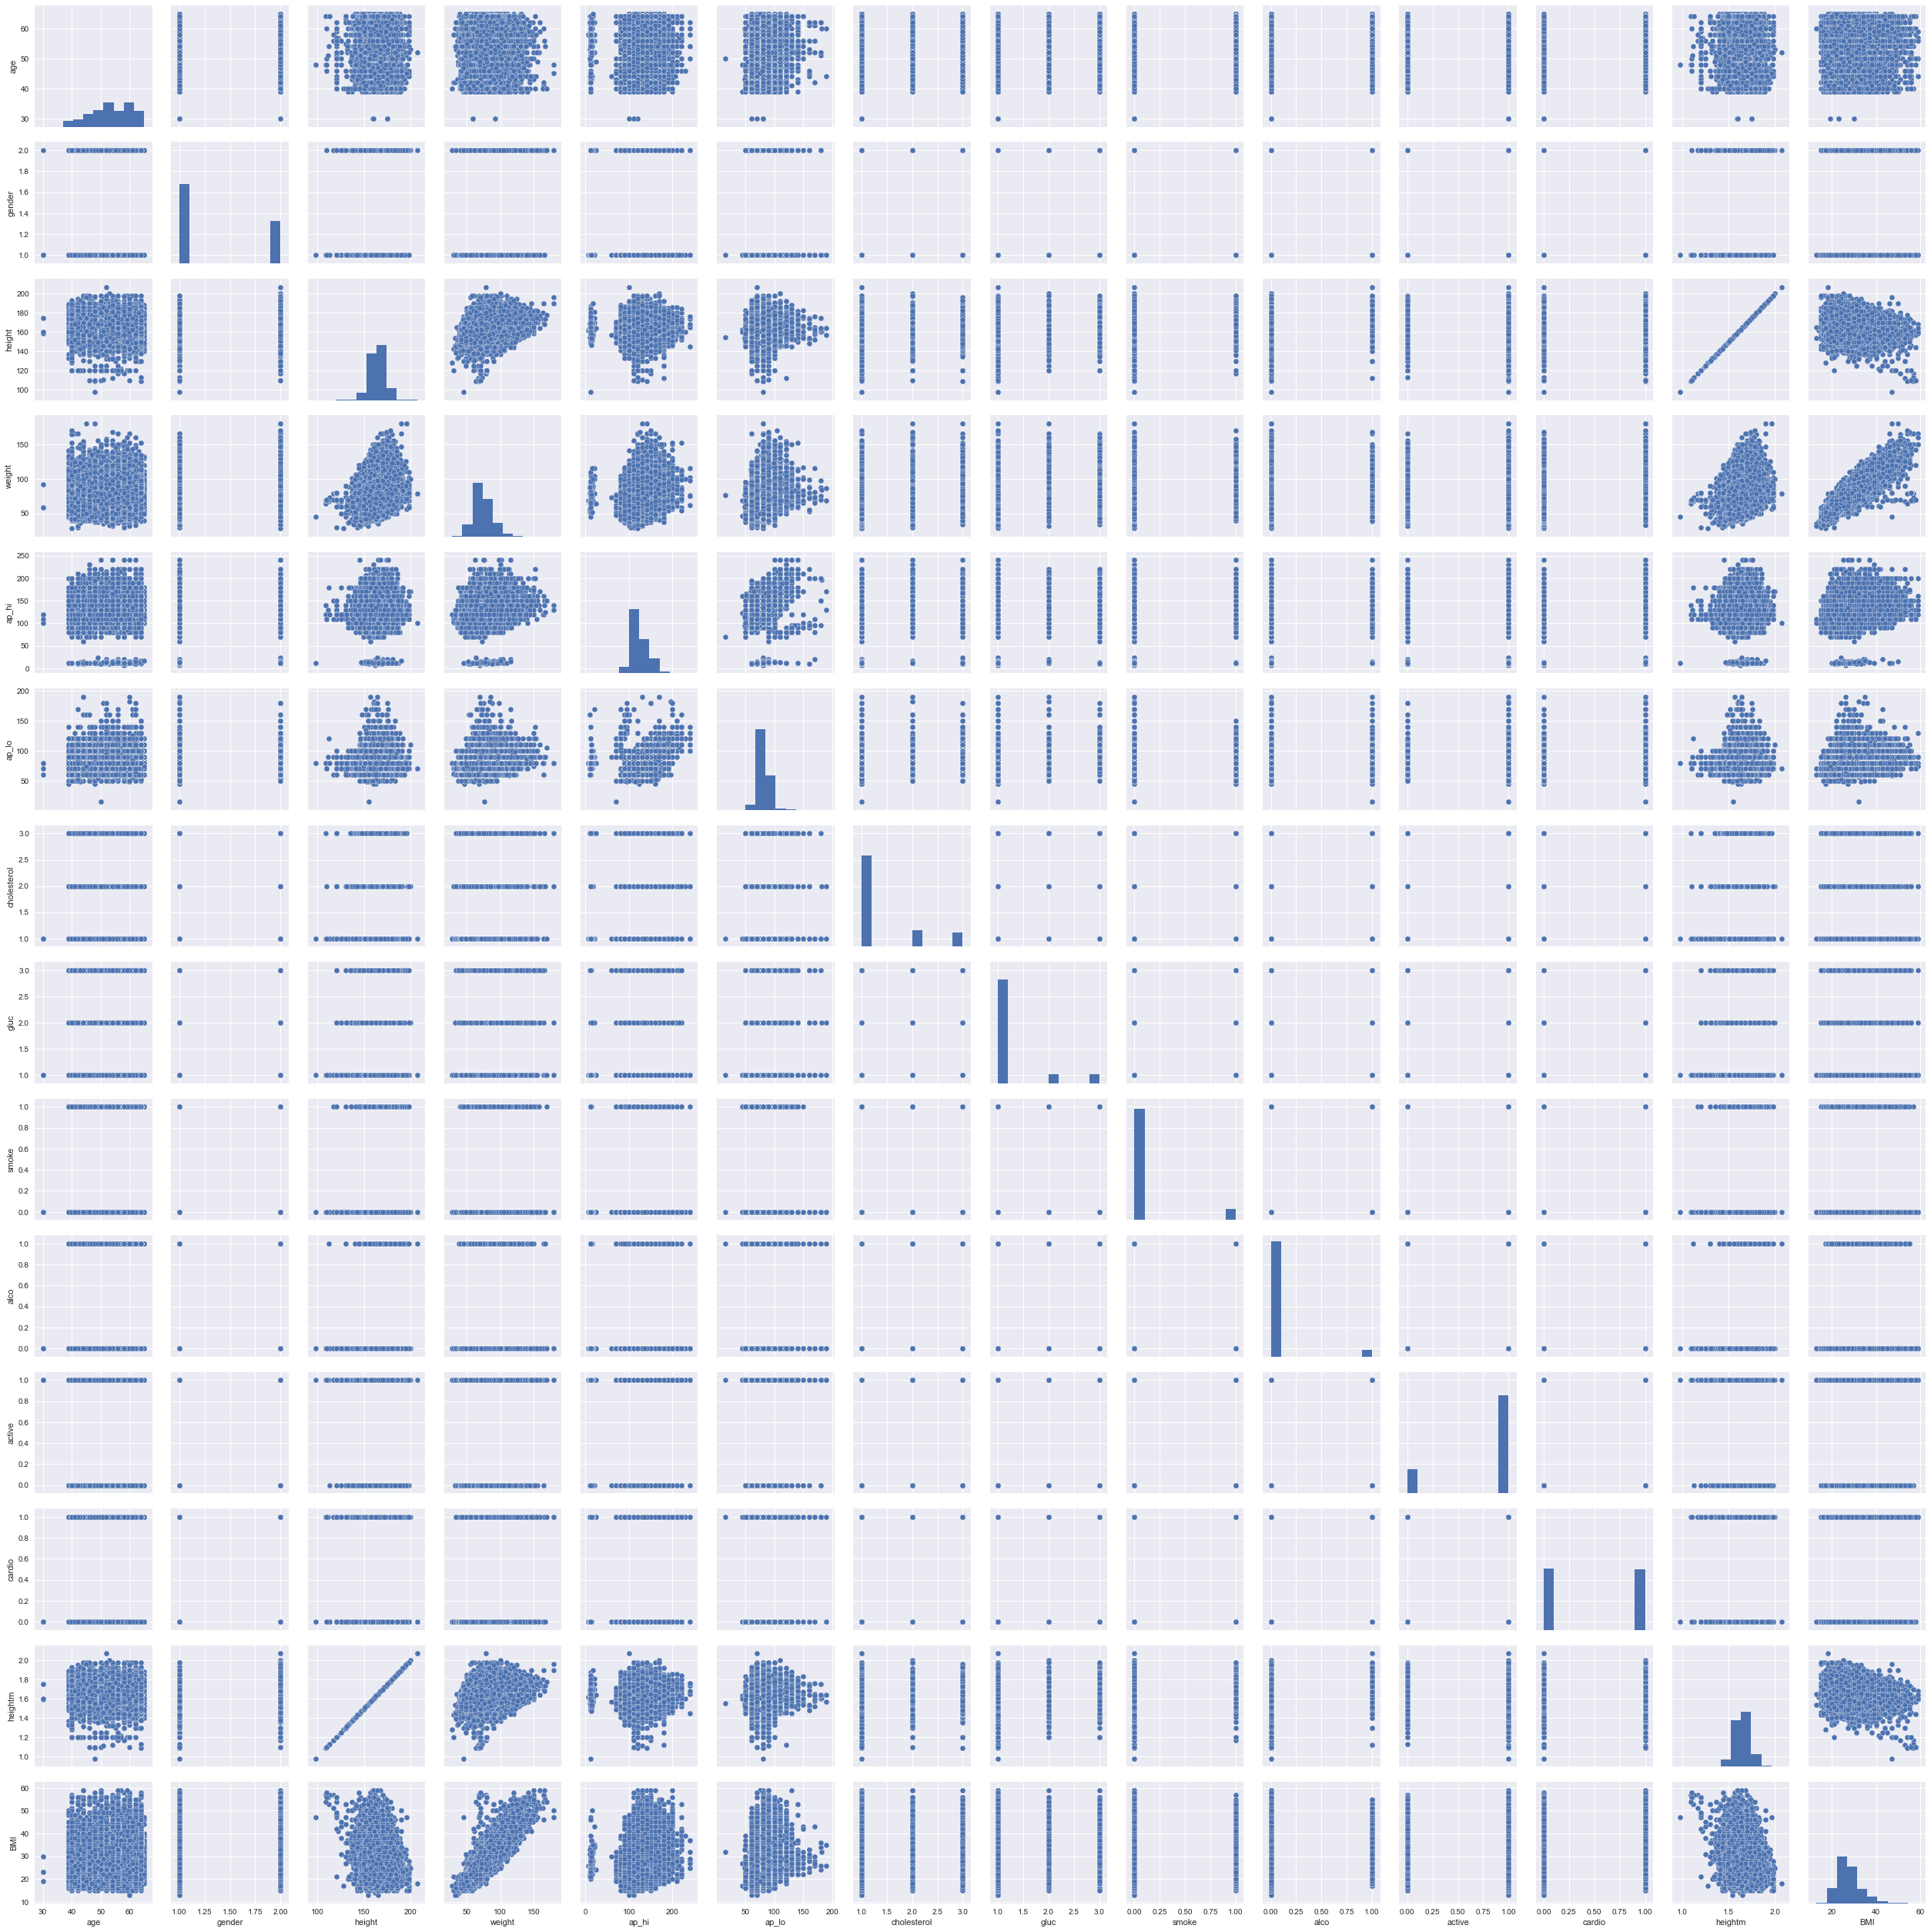

In [30]:
sns.pairplot(dataset)

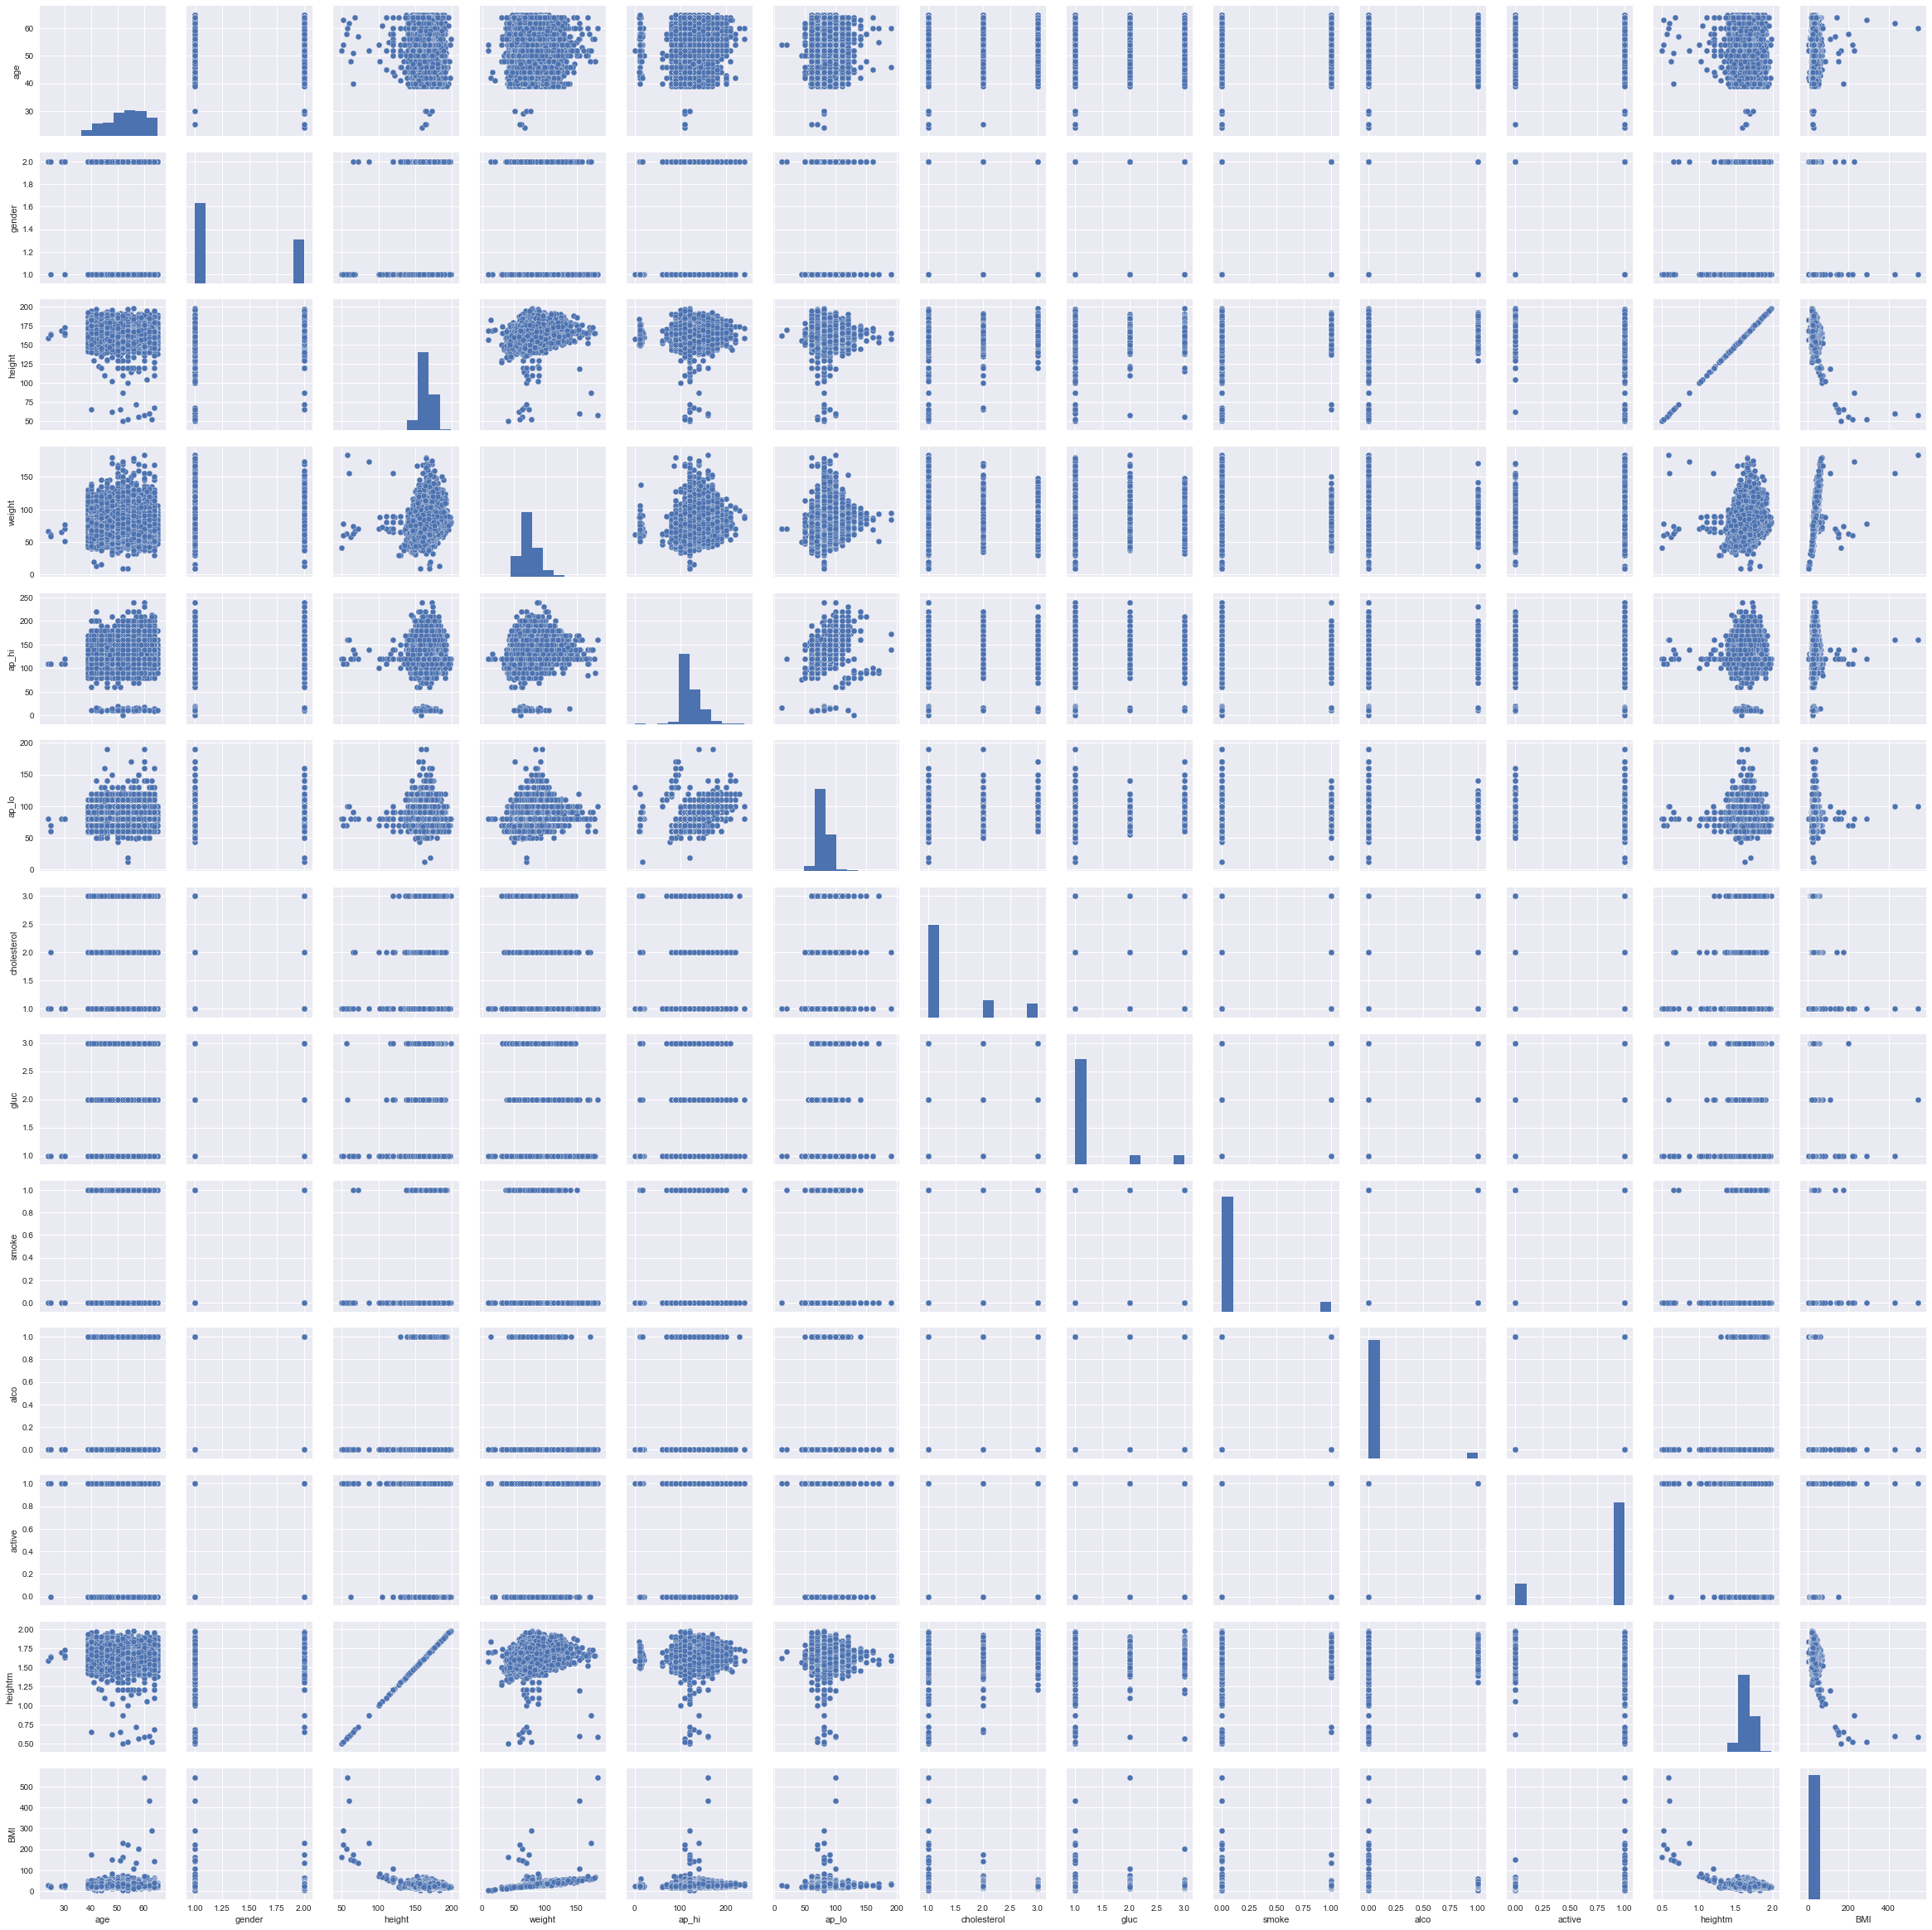

In [31]:
sns.pairplot(datasetTest)

In [32]:
#idx5 = dataset['BMI'] < 19
#dataset.loc[idx5, 'height'] = np.mean(dataset['height'])
#dataset.loc[idx5, 'weight'] = np.mean(dataset['weight'])


#dataset.loc[idx5, 'BMI'] = np.mean(dataset['BMI'])

#idx6 = dataset['BMI'] > 54
#dataset.loc[idx6, 'height'] = np.mean(dataset['height'])
#dataset.loc[idx6, 'weight'] = np.mean(dataset['weight'])

#dataset.loc[idx6, 'BMI'] = np.mean(dataset['BMI'])


#idx5t = datasetTest['BMI'] < 19
#datasetTest.loc[idx5t, 'height'] = np.mean(datasetTest['height'])
#datasetTest.loc[idx5t, 'weight'] = np.mean(datasetTest['weight'])


#dataset.loc[idx5, 'BMI'] = np.mean(dataset['BMI'])

#idx6t = datasetTest['BMI'] > 54
#datasetTest.loc[idx6t, 'height'] = np.mean(datasetTest['height'])
#datasetTest.loc[idx6t, 'weight'] = np.mean(datasetTest['weight'])

#dataset.loc[idx6, 'BMI'] = np.mean(dataset['BMI'])




In [33]:
dataset.describe()

age        gender        height        weight         ap_hi  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean      53.303157      1.349571    164.409800     74.161119    126.731129   
std        6.760171      0.476838      7.954397     14.215173     17.953723   
min       30.000000      1.000000     98.000000     28.000000      7.000000   
25%       48.000000      1.000000    159.000000     65.000000    120.000000   
50%       54.000000      1.000000    165.000000     72.000000    120.000000   
75%       58.000000      2.000000    170.000000     82.000000    140.000000   
max       65.000000      2.000000    207.000000    180.000000    240.000000   

              ap_lo   cholesterol          gluc         smoke          alco  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean      81.665800      1.366871      1.226457      0.088129      0.053771   
std        9.936529      0.680250      0.572270      0.283484      0.225568   
min       15.000000      1.000000      1.000000      0.000000      0.000000   
25%       80.000000      1.000000      1.000000      0.000000      0.000000   
50%       80.000000      1.000000      1.000000      0.000000      0.000000   
75%       90.000000      2.000000      1.000000      0.000000      0.000000   
max      190.000000      3.000000      3.000000      1.000000      1.000000   

             active        cardio       heightm           BMI  
count  70000.000000  70000.000000  70000.000000  70000.000000  
mean       0.803729      0.499700      1.644098     27.468729  
std        0.397179      0.500003      0.079544      5.225166  
min        0.000000      0.000000      0.980000     13.000000  
25%        1.000000      0.000000      1.590000     24.000000  
50%        1.000000      0.000000      1.650000     26.000000  
75%        1.000000      1.000000      1.700000     30.000000  
max        1.000000      1.000000      2.070000     59.000000

In [34]:
row = dataset.loc[dataset['weight'] < 40]

print(row)

        age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
3752   42.0       1     120   30.00    110     70            1     1      0   
5794   48.0       1     151   37.00    120     80            1     1      0   
10447  60.0       1     162   38.00    100     70            1     1      0   
10627  59.0       1     153   37.00    150     80            3     3      0   
11876  48.0       1     157   39.00     90     70            1     1      0   
14722  62.0       1     143   34.00    100     70            1     1      0   
16322  60.0       1     165   35.00    100     70            1     1      0   
19582  58.0       1     152   38.00    110     80            1     1      0   
22016  42.0       1     146   32.00    100     70            1     1      0   
25198  51.0       1     149   35.45    110     70            1     1      0   
29333  59.0       1     153   37.00    120     80            1     1      0   
31420  56.0       1     140   39.00    120     80   

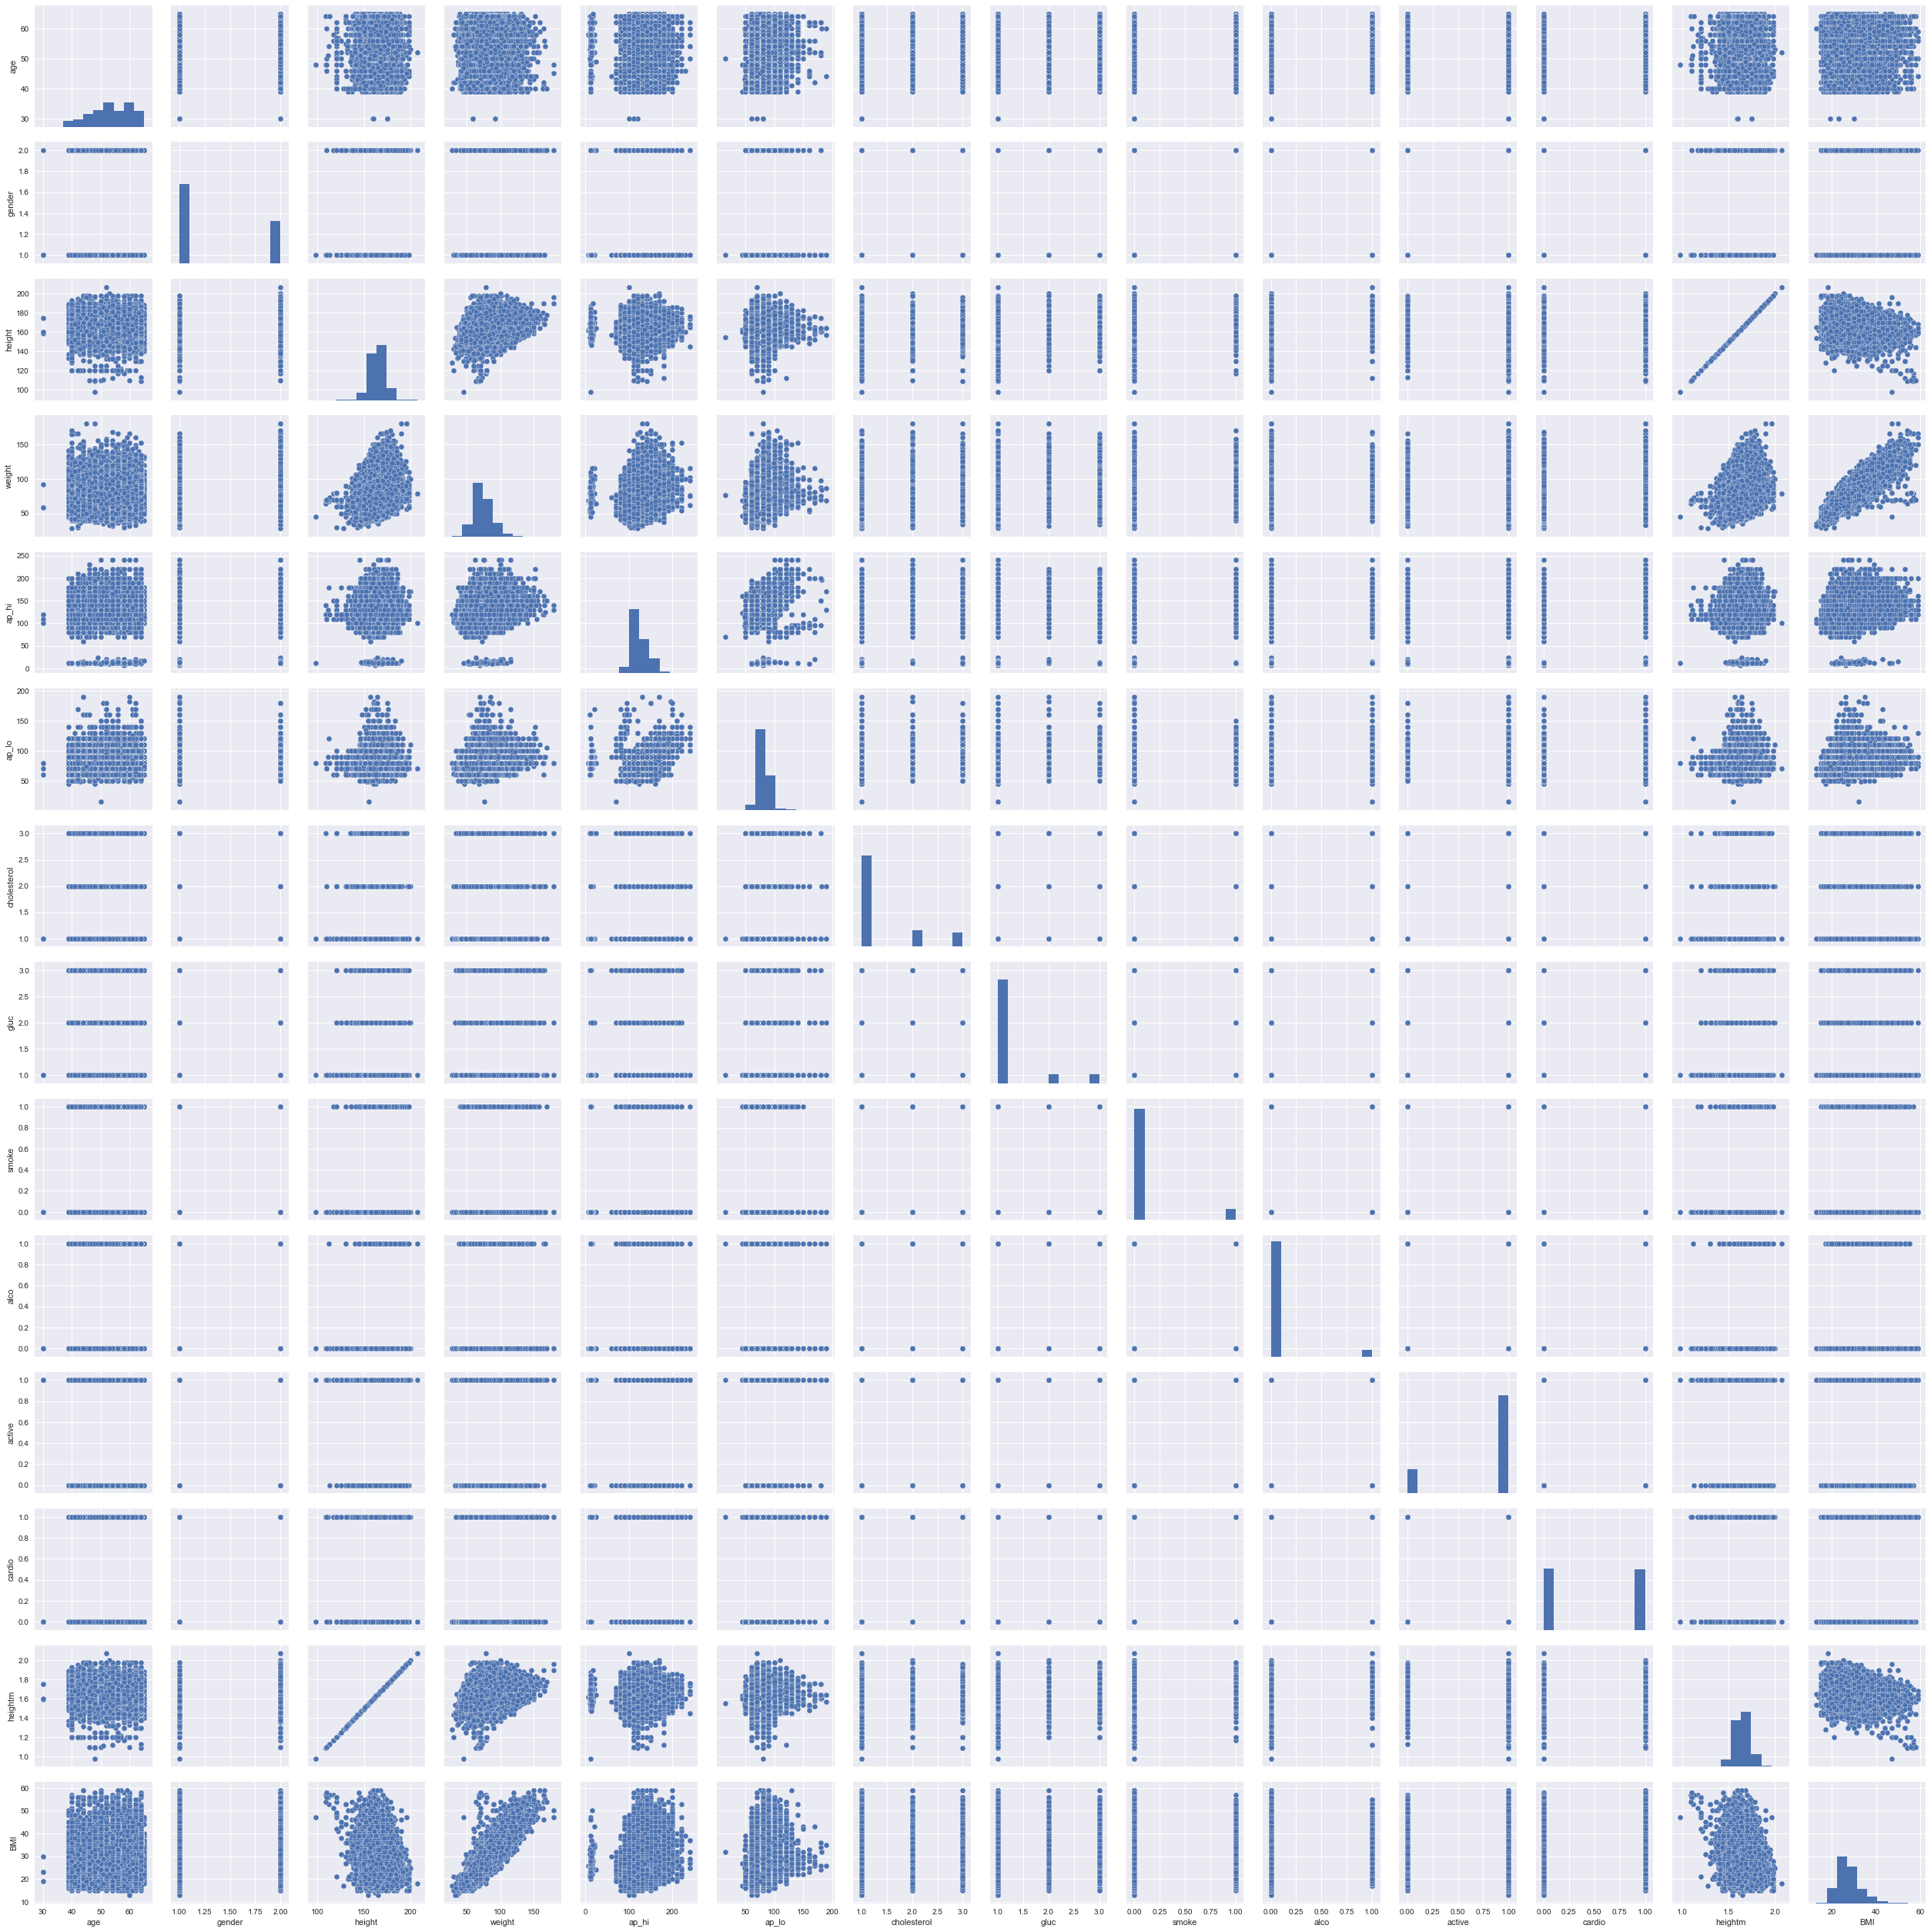

In [35]:
sns.pairplot(dataset)

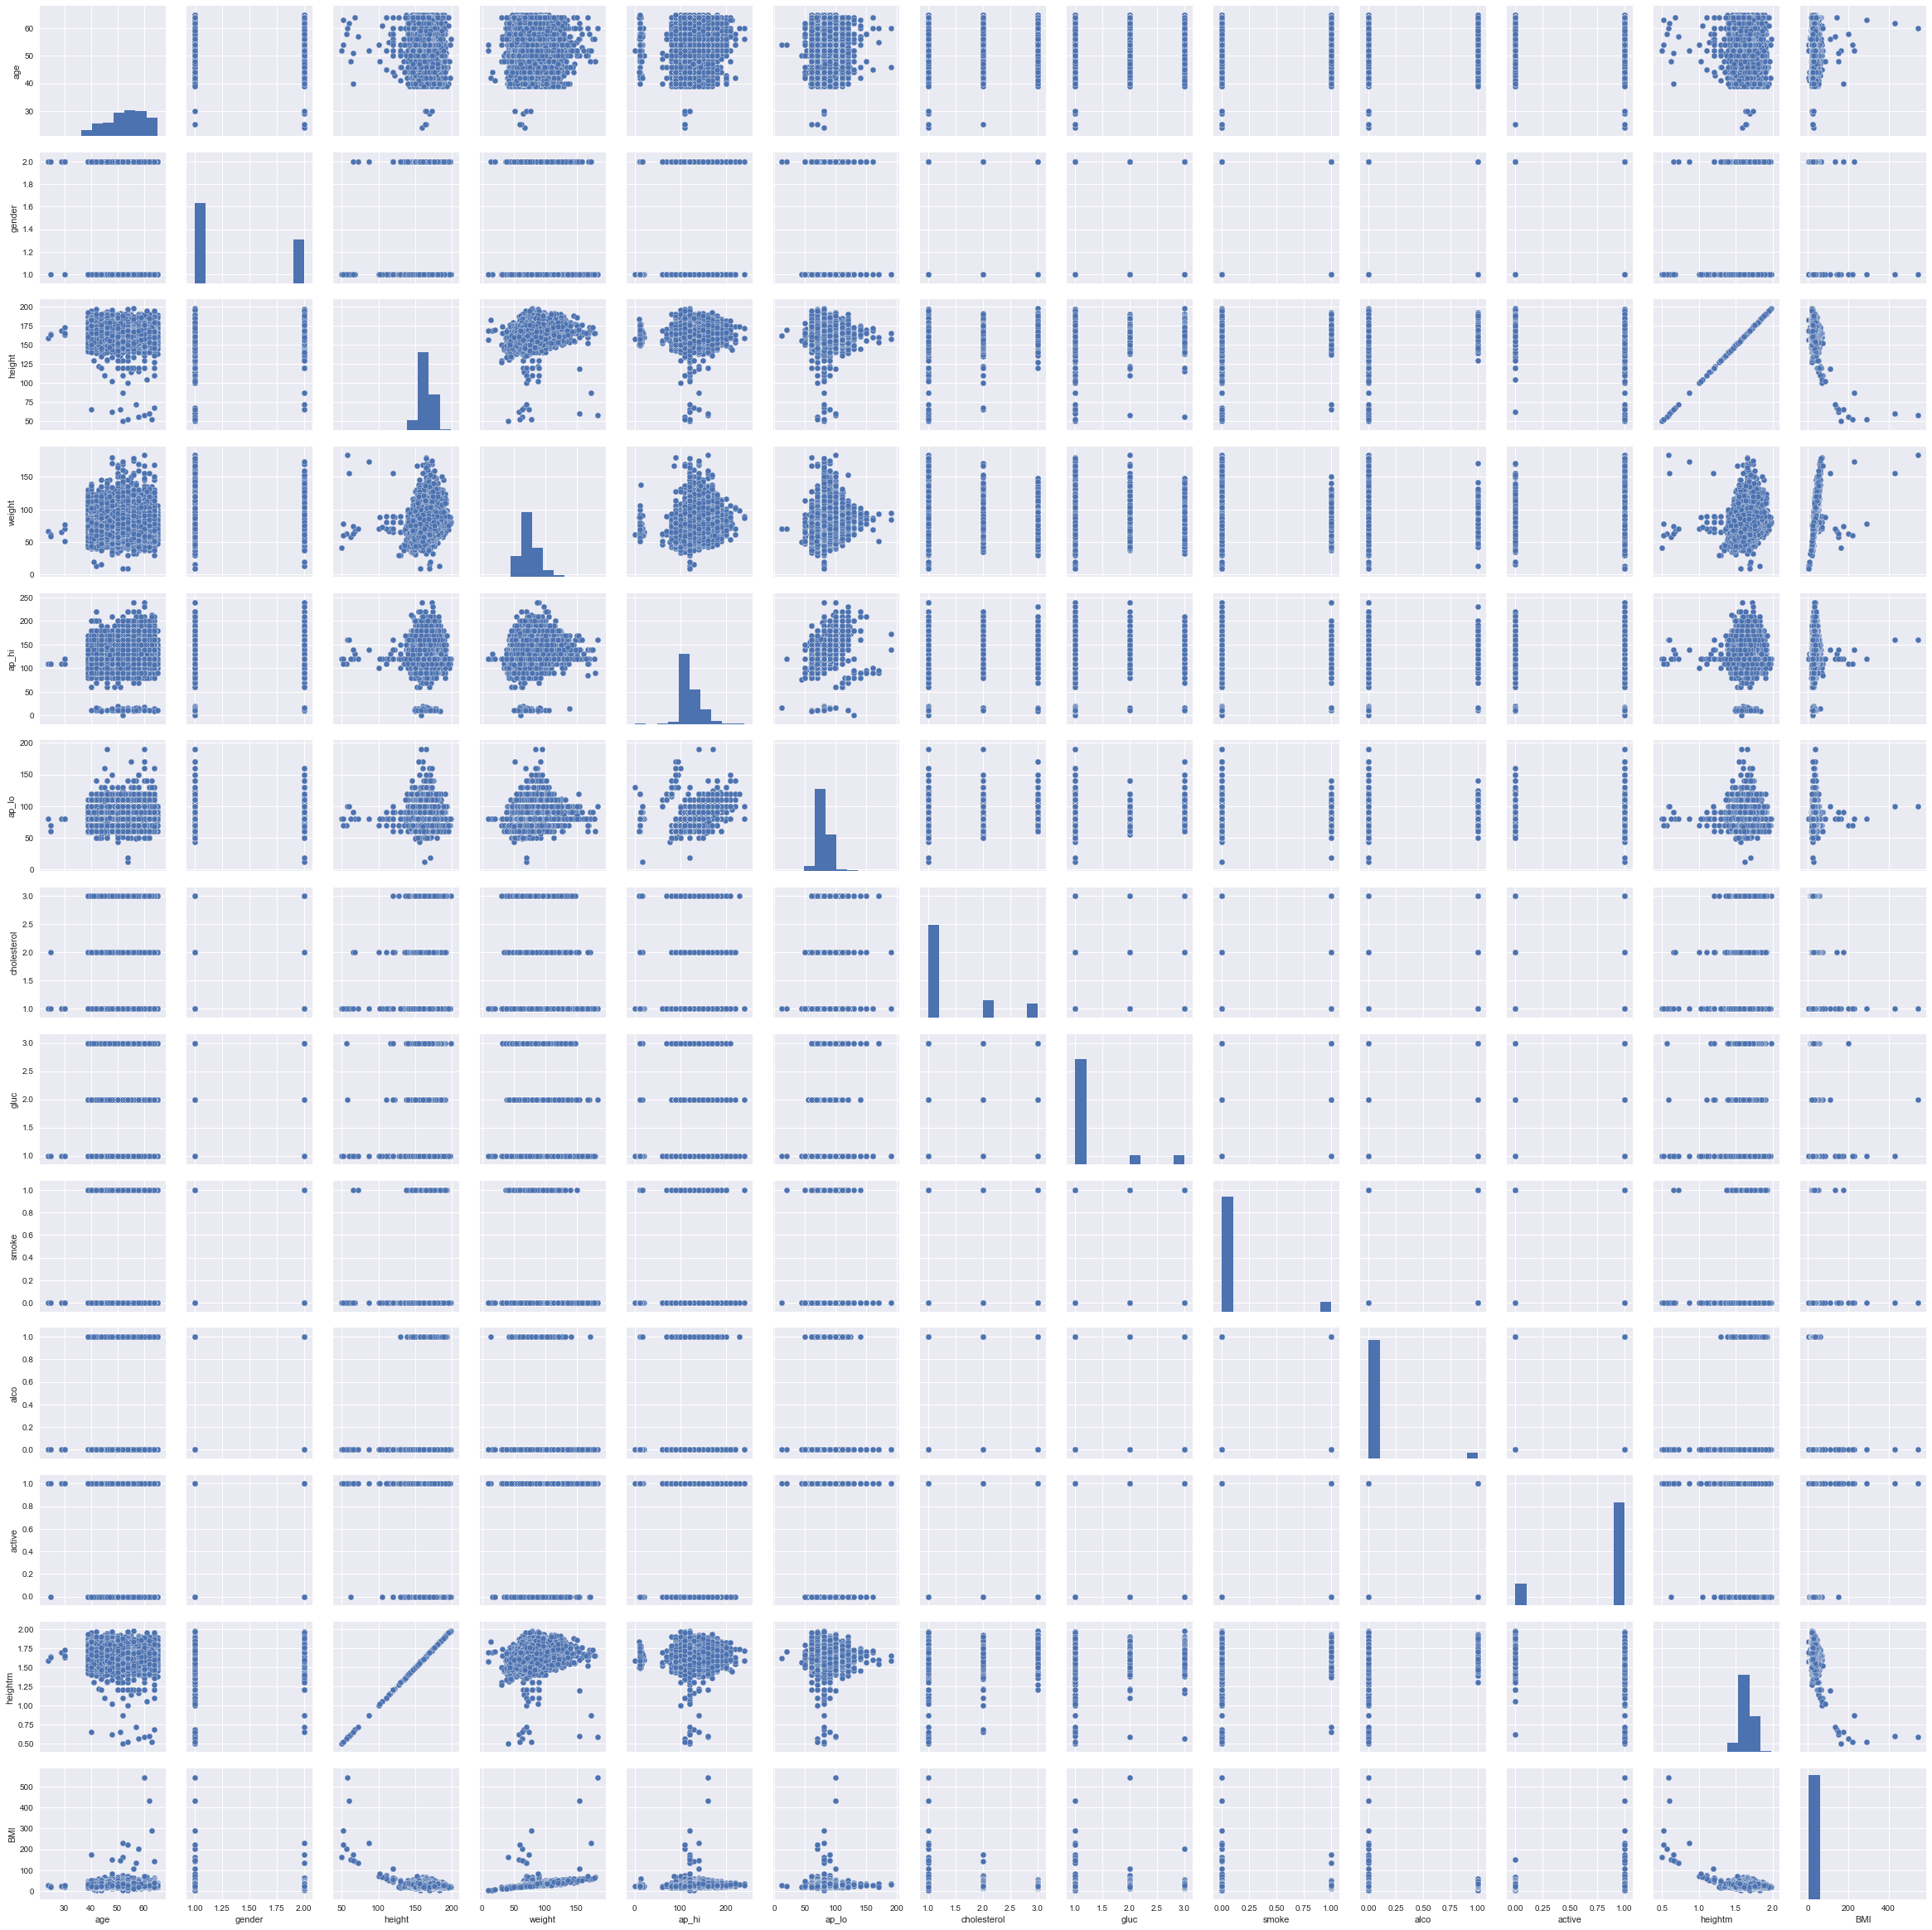

In [36]:
sns.pairplot(datasetTest)

In [37]:
dataset.gender.replace([1, 2], ['female', 'male'], inplace=True)
#dataset.cholesterol.replace([1, 2, 3], ['chollow', 'cholmiddle', 'cholhigh'], inplace=True)
#dataset.gluc.replace([1, 2, 3], ['gluclow', 'glucmiddle', 'gluchigh'], inplace=True)
dataset.smoke.replace([0, 1], ['smoke_no', 'smoke_yes'], inplace=True)
dataset.alco.replace([0, 1], ['alco_no', 'alco_yes'], inplace=True)
dataset.active.replace([0, 1], ['active_no', 'active_yes'], inplace=True)

datasetTest.gender.replace([1, 2], ['female', 'male'], inplace=True)
#datasetTest.cholesterol.replace([1, 2, 3], ['chollow', 'cholmiddle', 'cholhigh'], inplace=True)
#datasetTest.gluc.replace([1, 2, 3], ['gluclow', 'glucmiddle', 'gluchigh'], inplace=True)
datasetTest.smoke.replace([0, 1], ['smoke_no', 'smoke_yes'], inplace=True)
datasetTest.alco.replace([0, 1], ['alco_no', 'alco_yes'], inplace=True)
datasetTest.active.replace([0, 1], ['active_no', 'active_yes'], inplace=True)

In [38]:
datasetTest.head()

age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc     smoke  \
0  52.0  female     154    85.0    130     80            1     1  smoke_no   
1  52.0    male     170    69.0    130     90            1     1  smoke_no   
2  56.0  female     160    70.0    120     75            1     1  smoke_no   
3  50.0    male     185    94.0    130     90            1     1  smoke_no   
4  44.0    male     170    76.0    120     80            1     1  smoke_no   

      alco      active  heightm   BMI  
0  alco_no  active_yes     1.54  36.0  
1  alco_no  active_yes     1.70  24.0  
2  alco_no   active_no     1.60  27.0  
3  alco_no  active_yes     1.85  27.0  
4  alco_no  active_yes     1.70  26.0

In [39]:
gender_dummies = pd.get_dummies(dataset['gender'])
smoke_dummies = pd.get_dummies(dataset['smoke'])
alco_dummies = pd.get_dummies(dataset['alco'])
active_dummies = pd.get_dummies(dataset['active'])
#cholesterol_dummies = pd.get_dummies(dataset['cholesterol'])
#gluc_dummies = pd.get_dummies(dataset['gluc'])


datasetX = pd.concat([dataset,
                      gender_dummies,
                      smoke_dummies,
                      alco_dummies,
                      active_dummies],
                    # cholesterol_dummies,
                    # gluc_dummies],
                     axis=1)
datasetX = datasetX.drop('gender', axis=1)
datasetX = datasetX.drop('smoke', axis=1)
datasetX = datasetX.drop('alco', axis=1)
datasetX = datasetX.drop('active', axis=1)
#datasetX = datasetX.drop('cholesterol', axis=1)
#datasetX = datasetX.drop('gluc', axis=1)
datasetX = datasetX.drop('heightm', axis=1)
#datasetX = datasetX.drop('BMI', axis=1)
datasetX = datasetX.drop('height', axis=1)
datasetX = datasetX.drop('weight', axis=1)





gender_dummies = pd.get_dummies(datasetTest['gender'])
smoke_dummies = pd.get_dummies(datasetTest['smoke'])
alco_dummies = pd.get_dummies(datasetTest['alco'])
active_dummies = pd.get_dummies(datasetTest['active'])
#cholesterol_dummies = pd.get_dummies(datasetTest['cholesterol'])
#gluc_dummies = pd.get_dummies(datasetTest['gluc'])

XtestX = pd.concat([datasetTest,
                    gender_dummies,
                    smoke_dummies,
                    alco_dummies,
                    active_dummies],
                   # cholesterol_dummies,
                   #  gluc_dummies],
                   axis=1)
XtestX = XtestX.drop('gender', axis=1)
XtestX = XtestX.drop('smoke', axis=1)
XtestX = XtestX.drop('alco', axis=1)
XtestX = XtestX.drop('active', axis=1)
#XtestX = XtestX.drop('cholesterol', axis=1)
#XtestX = XtestX.drop('gluc', axis=1)
XtestX = XtestX.drop('heightm', axis=1)
#XtestX = XtestX.drop('BMI', axis=1)
XtestX = XtestX.drop('height', axis=1)
XtestX = XtestX.drop('weight', axis=1)

In [40]:
y = datasetX['cardio']
X = datasetX.drop(['cardio'], axis=1)

In [41]:
X.head()

age  ap_hi  ap_lo  cholesterol  gluc   BMI  female  male  smoke_no  \
0  50.0    110     80            1     1  22.0       0     1         1   
1  55.0    140     90            3     1  35.0       1     0         1   
2  52.0    130     70            3     1  24.0       1     0         1   
3  48.0    150    100            1     1  29.0       0     1         1   
4  48.0    100     60            1     1  23.0       1     0         1   

   smoke_yes  alco_no  alco_yes  active_no  active_yes  
0          0        1         0          0           1  
1          0        1         0          0           1  
2          0        1         0          1           0  
3          0        1         0          0           1  
4          0        1         0          1           0

In [42]:
XtestX.describe()

age         ap_hi         ap_lo   cholesterol          gluc  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      53.268833    126.768233     81.701433      1.368033      1.222700   
std        6.791487     17.816772      9.879279      0.679166      0.566494   
min       24.000000      1.000000     12.000000      1.000000      1.000000   
25%       48.000000    120.000000     80.000000      1.000000      1.000000   
50%       54.000000    120.000000     80.000000      1.000000      1.000000   
75%       58.000000    140.000000     90.000000      2.000000      1.000000   
max       65.000000    240.000000    190.000000      3.000000      3.000000   

                BMI        female          male      smoke_no     smoke_yes  \
count  30000.000000  30000.000000  30000.000000  30000.000000  30000.000000   
mean      27.552833      0.646267      0.353733      0.921033      0.078967   
std        7.155686      0.478136      0.478136      0.269691      0.269691   
min        4.000000      0.000000      0.000000      0.000000      0.000000   
25%       24.000000      0.000000      0.000000      1.000000      0.000000   
50%       26.000000      1.000000      0.000000      1.000000      0.000000   
75%       30.000000      1.000000      1.000000      1.000000      0.000000   
max      544.000000      1.000000      1.000000      1.000000      1.000000   

            alco_no      alco_yes     active_no    active_yes  
count  30000.000000  30000.000000  30000.000000  30000.000000  
mean       0.951033      0.048967      0.175333      0.824667  
std        0.215802      0.215802      0.380258      0.380258  
min        0.000000      0.000000      0.000000      0.000000  
25%        1.000000      0.000000      0.000000      1.000000  
50%        1.000000      0.000000      0.000000      1.000000  
75%        1.000000      0.000000      0.000000      1.000000  
max        1.000000      1.000000      1.000000      1.000000

In [43]:
kf = KFold(n_splits=5, shuffle=True, random_state=7)

In [44]:
kf.get_n_splits()

5

In [45]:
clf = ensemble.RandomForestClassifier(n_estimators=10)

In [46]:
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [47]:
clf.score(X, y)

0.86319999999999997

In [48]:
predicted = clf.predict_proba(X)

In [49]:
print(predicted)

[[ 0.95        0.05      ]
 [ 0.          1.        ]
 [ 0.2         0.8       ]
 ..., 
 [ 0.1         0.9       ]
 [ 0.3         0.7       ]
 [ 0.48944444  0.51055556]]


In [50]:
from sklearn.metrics import log_loss

In [51]:
log_loss(y, predicted)

0.31183761608774718

In [52]:
predictedTest = clf.predict_proba(XtestX)

In [53]:
print(predictedTest)

[[ 0.85        0.15      ]
 [ 0.46666667  0.53333333]
 [ 0.86444444  0.13555556]
 ..., 
 [ 0.71666667  0.28333333]
 [ 0.7         0.3       ]
 [ 0.71666667  0.28333333]]


In [54]:
pd.DataFrame(predictedTest, columns=clf.classes_)

0         1
0      0.850000  0.150000
1      0.466667  0.533333
2      0.864444  0.135556
3      0.325000  0.675000
4      0.727981  0.272019
5      0.893333  0.106667
6      1.000000  0.000000
7      0.827060  0.172940
8      1.000000  0.000000
9      0.100000  0.900000
10     0.300000  0.700000
11     0.758183  0.241817
12     0.400000  0.600000
13     1.000000  0.000000
14     0.884974  0.115026
15     0.733333  0.266667
16     0.520191  0.479809
17     0.401190  0.598810
18     1.000000  0.000000
19     1.000000  0.000000
20     0.800000  0.200000
21     0.900000  0.100000
22     0.100000  0.900000
23     0.300000  0.700000
24     0.777491  0.222509
25     0.500000  0.500000
26     0.000000  1.000000
27     0.100000  0.900000
28     0.316667  0.683333
29     0.000000  1.000000
...         ...       ...
29970  0.700000  0.300000
29971  0.166667  0.833333
29972  0.100000  0.900000
29973  0.000000  1.000000
29974  0.711314  0.288686
29975  0.500000  0.500000
29976  0.200000  0.800000
29977  0.820000  0.180000
29978  0.100000  0.900000
29979  0.463370  0.536630
29980  0.410238  0.589762
29981  0.637752  0.362248
29982  0.500000  0.500000
29983  0.300000  0.700000
29984  0.500000  0.500000
29985  0.357857  0.642143
29986  0.800000  0.200000
29987  0.100000  0.900000
29988  0.800000  0.200000
29989  0.000000  1.000000
29990  0.150000  0.850000
29991  0.900000  0.100000
29992  0.800000  0.200000
29993  0.000000  1.000000
29994  0.966667  0.033333
29995  0.200000  0.800000
29996  0.798828  0.201172
29997  0.716667  0.283333
29998  0.700000  0.300000
29999  0.716667  0.283333

[30000 rows x 2 columns]

In [55]:
df = pd.DataFrame(predictedTest)
df = df.drop(0, axis=1)

dftrain = pd.DataFrame(predicted)
dftrain = dftrain.drop(0, axis=1)

In [56]:
df.describe()

1
count  30000.000000
mean       0.495206
std        0.329380
min        0.000000
25%        0.200792
50%        0.462500
75%        0.800000
max        1.000000

In [57]:
dftrain.describe()

1
count  70000.000000
mean       0.499490
std        0.355864
min        0.000000
25%        0.197819
50%        0.433333
75%        0.900000
max        1.000000

In [58]:
df.head()

1
0  0.150000
1  0.533333
2  0.135556
3  0.675000
4  0.272019

In [59]:
df.to_csv('probabilities.csv', index=False, header = False, encoding='utf-8')

In [60]:
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

/Users/vzvsuwork/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [61]:
#xlf = XGBClassifier()
#xlf.fit(X, y)

In [62]:
#xlf.score(X, y)

In [63]:
xgbtrain = xgb.DMatrix(X, y)
xgbtest = xgb.DMatrix(XtestX)

In [64]:
%%time
parameters = {
              'objective':'binary:logistic',
              'max_depth': 4,
              'eta': 0.01,
              'silent': 0,
              'subsample': 0.8,
              'colsample_bytree': 0.8,
              'seed': 202
             }
parameters['eval_metric'] = 'logloss'
trees = 5000
cv = xgb.cv(parameters, xgbtrain, metrics=('logloss'), show_stdv=True,
            num_boost_round=trees,nfold=5,early_stopping_rounds = 50)

CPU times: user 3min 18s, sys: 1.98 s, total: 3min 20s
Wall time: 3min 22s


test-logloss-mean     0.538383
test-logloss-std      0.001582
train-logloss-mean    0.530729
train-logloss-std     0.000380
Name: 1254, dtype: float64


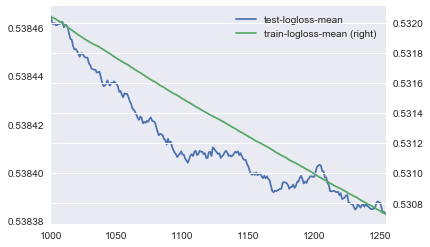

In [65]:
cv[1000:].plot(y=['test-logloss-mean', 'train-logloss-mean'],
               secondary_y='train-logloss-mean')
print (cv.loc[cv['test-logloss-mean'].argmin()])
trees = cv['test-logloss-mean'].argmin()

In [66]:
%%time
bst = xgb.train(parameters,xgbtrain,trees)
xgbprobabilities = pd.DataFrame()

CPU times: user 42.4 s, sys: 378 ms, total: 42.7 s
Wall time: 43 s


In [67]:
xgbprobabilities['y'] = bst.predict(xgbtest)
xgbprobabilities.to_csv('probabilities_xgboost.csv', index = False, header = False)

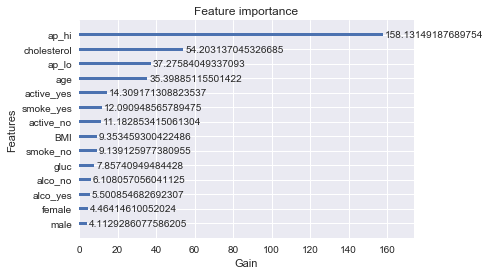

In [68]:
xgb.plot_importance(bst, importance_type='gain', xlabel='Gain')

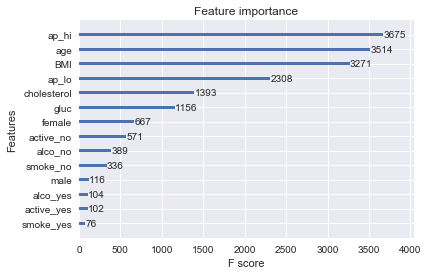

In [69]:
xgb.plot_importance(bst)

In [70]:
importances = bst.get_fscore()
importances

{'BMI': 3271,
 'active_no': 571,
 'active_yes': 102,
 'age': 3514,
 'alco_no': 389,
 'alco_yes': 104,
 'ap_hi': 3675,
 'ap_lo': 2308,
 'cholesterol': 1393,
 'female': 667,
 'gluc': 1156,
 'male': 116,
 'smoke_no': 336,
 'smoke_yes': 76}

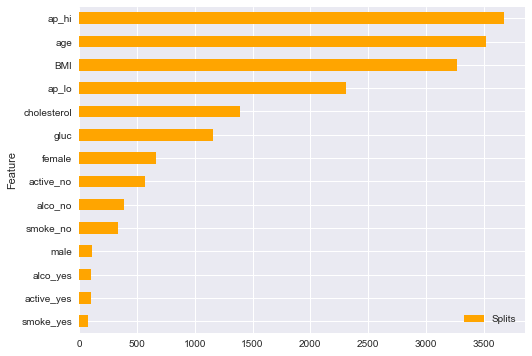

In [71]:
importance_df = pd.DataFrame({
    'Splits': list(importances.values()),
    'Feature': list(importances.keys())
})
importance_df.sort_values(by='Splits', inplace=True)
importance_df.plot(kind='barh', x='Feature', figsize=(8,6), color='orange')